### Dataset Creation

This is the notebook to train the classification of Diabetic Retinography with CNNs

This notebook contains the following
1. Dataset Creation and Augmentation
2. Train and Eval Functions
3. CNN Class Models (InceptionV3, ResNet50, ResNet152, EfficientNet, DenseNet, VGG16, MaxViT)

This notebook assumes the following project structure:
```bash
Root
├── notebooks
│   └── notebook1.ipynb
└── input
    └── Data
        ├── DDR
        │   ├── Train
        │   └── Test
        ── BEN
        │   ├── Train
        │   └── Test
        ├── CLAHE
        │   ├── Train
        │   └── Test
        ├── UNET_Binary
        │   ├── Train
        │   └── Test
        └── UNET_Multiclass
            ├── Train
            └── Test
```

If you do not have the dataset, please download it from our Google Drive

In [ ]:
#Necessary Imports
import torch
from torchvision import datasets, transforms, models
from torchvision.transforms import InterpolationMode
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from tqdm import tqdm
import gc

### Dataset Creation

In [ ]:
# Parameter required
image_size = (224,224)
batch_size = 64

# Defining Train Transforms
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontally with a 50% probability
    transforms.RandomVerticalFlip(p=0.5),  # Flip vertically with a 50% probability
    transforms.RandomAffine(
        degrees=360,  # Rotation
        translate=(0.1, 0.1),  # Translation
        scale=(0.8, 1.2) #Zooming
    ),
    transforms.ToTensor()
])


# Defining Evaluation Transforms, no data augmentation
eval_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

#### Ben Graham dataset

In [ ]:
# Create PyTorch datasets for training and validation
ben_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/BEN/train', 
                    transform=train_transform
                    )
ben_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/BEN/val', 
                    transform=eval_transform
                    )
ben_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/BEN/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
ben_train_dataloader = torch.utils.data.DataLoader(
                    ben_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
ben_val_dataloader = torch.utils.data.DataLoader(
                    ben_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
ben_test_dataloader = torch.utils.data.DataLoader(
                    ben_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### CLAHE dataset

In [ ]:
# Create PyTorch datasets for training and validation
clahe_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/CLAHE/train', 
                    transform=train_transform
                    )
clahe_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/CLAHE/val', 
                    transform=eval_transform
                    )
clahe_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/CLAHE/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
clahe_train_dataloader = torch.utils.data.DataLoader(
                    clahe_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
clahe_val_dataloader = torch.utils.data.DataLoader(
                    clahe_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
clahe_test_dataloader = torch.utils.data.DataLoader(
                    clahe_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### UNET_Binary Dataset

In [ ]:
# Create PyTorch datasets for training and validation
unetb_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Binary/train', 
                    transform=train_transform
                    )
unetb_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Binary/val', 
                    transform=eval_transform
                    )
unetb_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Binary/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
unetb_train_dataloader = torch.utils.data.DataLoader(
                    unetb_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetb_val_dataloader = torch.utils.data.DataLoader(
                    unetb_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetb_test_dataloader = torch.utils.data.DataLoader(
                    unetb_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### UNET_Multiclass Dataset

In [ ]:
# Create PyTorch datasets for training and validation
unetm_train_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Multiclass/train', 
                    transform=train_transform
                    )
unetm_val_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Multiclass/val', 
                    transform=eval_transform
                    )
unetm_test_dataset = datasets.ImageFolder(
                    root='../input/grading_images/UNET_Multiclass/test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
unetm_train_dataloader = torch.utils.data.DataLoader(
                    unetm_train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetm_val_dataloader = torch.utils.data.DataLoader(
                    unetm_val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
unetm_test_dataloader = torch.utils.data.DataLoader(
                    unetm_test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

#### Visualisation

In [ ]:
def visualise_img(dataloader, class_list: list):
    """
    Function to visualize the first 9 images of the dataset.

    Args:
        dataloader (DataLoader): PyTorch DataLoader object containing the dataset to visualize.
        class_list (list): List of class labels.
    """
    #Get the first batch of images and labels
    train_images, train_labels = next(iter(dataloader))
    batch_size = train_images.size(0)  # Get the batch size

    #Print the shape of the batch
    print(f"Images batch shape: {train_images.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

    #Create a 3x3 grid for visualization
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))

    for i in range(3):
        for j in range(3):
            #Get the index of the image in the batch
            index = i * 3 + j

            if index < batch_size:
                #Prepare image to print
                img = train_images[index].squeeze().numpy().transpose((1, 2, 0))
                label = train_labels[index].item()

                #Plot the image
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                axes[i, j].set_title(f'Label: {label}, {class_list[label]}', loc='left')

    plt.tight_layout()
    plt.show()

In [ ]:
visualise_img(ben_train_dataloader, ben_train_dataset.classes)

In [ ]:
visualise_img(clahe_train_dataloader, clahe_train_dataset.classes)

In [ ]:
visualise_img(unetb_train_dataloader, unetb_train_dataset.classes)

In [ ]:
visualise_img(unetm_train_dataloader, unetm_train_dataset.classes)

### Train, Eval Functions

In [ ]:
def calculate_dr_class_weights(dataset):
    """
    Function to calculate class weights
    Class Weights of i = Total Num of Samples / Total Num of samples of Class i * Num of classes

    We calculate the average of samples per class if it was equally distributed and then calculate the class weights based on the difference of actual vs ideal

    Args:
        dataset: train dataset

    Returns:
        weights (np.ndarray): array of size n_classes with the weights of each class in each index
    """
    # Counting the number of samples in each class
    class_counts = np.bincount(dataset.targets)
    total_samples = sum(class_counts)
    num_classes = len(class_counts)
    
    # Calculating class weights inversely proportional to the number of samples in each class
    weights = total_samples / (num_classes * class_counts)

    print("Class Weights:", weights)
    
    return weights

In [ ]:
import torch

def eval(model, 
         criterion, 
         img_size:tuple,
         val_dataloader, 
         device='cuda'):
    """
    Evaluation function for finetuning CNN models with a model object,
    incorporating average sensitivity for a multiclass problem.

    Sensitivity function: True Positives / (True Positives + False Negatives)

    Args:
        model: model to be trained
        criterion: loss function
        img_size (tuple): image size of dataset for model. All inputs will be resized to image size
        val_dataloader: val / test dataloader
        device (str, optional): 'cpu' or 'cuda', defaults to cuda.

    Returns:
        val_loss: float of the average val loss.
        val_accuracy: float of the accuracy.
        val_sensitivity: float of the average sensitivity across all classes.
    """

    model = model.to(device)
    
    #set model to eval mode
    model.eval()

    #variables 
    val_loss = 0.0
    correct = 0
    total = 0
    n_classes = 5
    true_positives = [0] * n_classes #stores num of true positives per class
    actual_positives = [0] * n_classes #stores total number of positives per class
    total_sensitivity = 0

    with torch.no_grad():
        for image, label in val_dataloader:
            batch_sensitivity = 0

            #resize image with bilinear, same as torchvision.transforms.Resize()
            image = torch.nn.functional.interpolate(image, size=img_size, mode='bilinear') 
            image, label = image.to(device), label.to(device)

            outputs = model(image)  #predict label
            loss = criterion(outputs, label)  #calculate loss
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1) #get prediction
            total += label.size(0)
            correct += (predicted == label).sum().item()

            for i in range(n_classes):
                true_positives[i] += ((predicted == i) & (label == i)).sum().item() #true positives
                actual_positives[i] += (label == i).sum().item() #true positives + false negatives
            
                if (label == i).sum().item() > 0:
                    batch_sensitivity += true_positives[i] / actual_positives[i]

                else:
                    pass
            
            total_sensitivity += batch_sensitivity/n_classes #average sensitivity for batch

    # Calculate accuracy, avg loss, and avg sensitivity
    accuracy = (correct / total) * 100
    avg_val_loss = val_loss / len(val_dataloader)
    avg_sensitivity = total_sensitivity/len(val_dataloader)
    
    return avg_val_loss, accuracy, avg_sensitivity


In [ ]:
def train(model, 
          criterion, 
          optimiser, 
          img_size:tuple,
          train_dataloader, 
          val_dataloader=None, 
          saving_metric:str='sensitivity',
          num_epochs:int=25, 
          device:str='cuda', 
          model_name:str=None):
    """
    Training Function to train model
    Runs validation for each epoch to calculate: Validation Loss, Validation Accuracy, Validation Sensitivity
    Best and last model will be saved to ../models/cnn under {model_name}_best.pt and {model_name}_last.pt
    
    Args:
        model: model to be trained
        criterion: loss function
        optimiser: optimiser chosen
        img_size (tuple): image size of dataset for model. All inputs will be resized to image size
        train_dataloader: train dataloader
        val_dataloader (optional): val dataloader, if None no validation will be calculated. Defaults to None.
        saving_metric (str, optional): saving metrics for best model, either "loss", "accuracy", or "sensitivity". Defaults to 'sensitivity'.
        num_epochs (int, optional): number of training epochs. Defaults to 25.
        device (str, optional): cuda or cpu. Defaults to 'cuda'.
        model_name (str, optional): model name to be saved, if None no model will be saved. Defaults to None.

    Returns:
        results_dataframe: dataframe of [model, train_loss, val_loss, val_accuracy, val_sensitivity] where each row is each epoch
    """

    if saving_metric not in ["loss", "accuracy", "sensitivity"]:
        raise Exception("Invalid saving metrics found, please only use loss, accuracy or sensitivity")

    #initialising results container
    results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])
    
    #placeholders
    val_loss = ''
    val_accuracy = ''
    val_sensitivity = ''


    for epoch in range(num_epochs):

        #initialising training
        model.train()
        training_loss = 0.0

        for image, label in tqdm(train_dataloader):
            
            #resize image with bilinear, same as torchvision.transforms.Resize()
            image = torch.nn.functional.interpolate(image, size=img_size, mode='bilinear') 
            image, label = image.to(device), label.to(device)

            optimiser.zero_grad()
            outputs = model(image)
            #calculate loss and train model
            loss = criterion(outputs, label)
            loss.backward()
            optimiser.step()
            training_loss += loss.item() #update the training loss

        epoch_loss = training_loss / len(train_dataloader) #calculate training loss in epoch
        print(f"Epoch {epoch+1} completed, training loss: {epoch_loss}")

        #validation
        if val_dataloader is not None:
            model.eval()  #set model to evaluate mode
            val_loss, val_accuracy,  val_sensitivity = eval(model=model, 
                                                               criterion=criterion,
                                                                val_dataloader=val_dataloader, 
                                                                img_size = img_size,
                                                                device=device) 
            
            print(f"Validation loss: {val_loss}, Validation Accuracy: {val_accuracy:.2f}, Validation Sensitivty: {val_sensitivity:2f}")
            

            if saving_metric == 'loss' and len(results) > 0 and val_loss < min(results['val loss'].to_list()):
                torch.save(model, f'../models/cnn/{model_name}_best.pt')
                print("Best model saved")

            elif saving_metric == 'accuracy' and len(results) > 0 and val_accuracy > max(results['val accuracy'].to_list()):
                torch.save(model, f'../models/cnn/{model_name}_best.pt')
                print("Best model saved")

            elif saving_metric == 'sensitivity' and len(results) > 0 and val_sensitivity > max(results['val sensitivity'].to_list()):
                torch.save(model, f'../models/cnn/{model_name}_best.pt')
                print("Best model saved")
            
        #updating results
        results.loc[len(results)] = [model_name, epoch_loss, val_loss, val_accuracy, val_sensitivity]


    #save the last model
    if model_name is not None:
        torch.save(model, f'../models/cnn/{model_name}_last.pt')

    return results


### Model

In [ ]:
class PreTrainedCNNModels(torch.nn.Module):
    def __init__(self, model_type:str, num_first_unfreeze:int, num_last_unfreeze:int, num_class:int):
        super(PreTrainedCNNModels, self).__init__()
        """
        Class that contains InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit fine tuned models

        Args:
            model_type (str): Determines which pre-trained models to use
                              Must be: InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit
            num_first_unfreeze (int): Number of first layers to unfreeze and finetune
            num_last_unfreeze (int): Number of layers to unfreeze and finetune
            num_class (int): Number of output classes for the classification
        """
        #selecting model type
        if model_type == 'InceptionV3':
            self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
            self.model.aux_logits = False

        elif model_type == 'Resnet50':
            self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        elif model_type == 'Resnet152':
            self.model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

        elif model_type == 'EfficientNet':
            self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

        elif model_type == 'DenseNet':
            self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        
        elif model_type == 'VGG16':
            self.model = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)

        elif model_type == 'MaxVit':
            self.model = models.maxvit_t(weights=models.MaxVit_T_Weights.DEFAULT)
        
        else:
            raise Exception("Invalid model type chosen. Please select one of the following\n[InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit]")

        
        #modifying final layer
        if model_type in ['InceptionV3', 'Resnet50', 'Resnet152']:
            self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_class)

        elif model_type == 'DenseNet':
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, num_class)

        else:
            self.model.classifier[-1] = torch.nn.Linear(self.model.classifier[-1].in_features, num_class)


        model_paramteres = list(self.model.parameters())
        #unfreeze last num_last_unfreeze layers
        for param in model_paramteres[-num_last_unfreeze:]:
            param.requires_grad = True

        #unfreeze first num_first_unfreeze layers 
        for param in model_paramteres[:num_first_unfreeze]:
            param.requires_grad = True
            
        #freeze rest of the layers
        for param in model_paramteres[num_first_unfreeze:-num_last_unfreeze]:
            param.requires_grad = False


    def forward(self, images):
        return self.model(images)

### maxvit Layers

clahe data

In [ ]:
class_weights = calculate_dr_class_weights(clahe_test_dataset)

In [ ]:
layer_list = [[0, 2],
              [1, 2],
              [0, 8],
              [1, 8],
              [0, 16],
              [1, 16],
              [0, 32],
              [1, 32]]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30

all_results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    model = PreTrainedCNNModels("MaxVit", num_first_unfreeze, num_last_unfreeze, len(clahe_train_dataset.classes)).to(device)
    criterion=torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    print(f"-------------Training MaxVit with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers with clahe data------------")
    model_result = train(model,
                         criterion,
                         optimizer,
                         (224,224),
                         clahe_train_dataloader,
                         clahe_val_dataloader,
                         'sensitivity',
                         num_epochs,
                         device,
                         f"MaxVit_{num_first_unfreeze}_{num_last_unfreeze}_clahe")
    
    all_results =  pd.concat([all_results, model_result])

all_results.to_csv("results/maxvit_layer_clahe.csv")


In [ ]:
layer_list = [[0, 2],
              [1, 2],
              [0, 8],
              [1, 8],
              [0, 16],
              [1, 16],
              [0, 32],
              [1, 32]]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    best_model = torch.load(f'../models/cnn/MaxVit_{num_first_unfreeze}_{num_last_unfreeze}_clahe_best.pt')
    last_model = torch.load(f'../models/cnn/MaxVit_{num_first_unfreeze}_{num_last_unfreeze}_clahe_last.pt')
    criterion=torch.nn.CrossEntropyLoss()

    print(f"-------------Evaluating Maxvit with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers with clahe data------------")
    loss, accuracy, sensitivity = eval(best_model,
                                        criterion,
                                        (224,224),
                                        clahe_test_dataloader,
                                        device)
    print(f"Best Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}")
    loss, accuracy, sensitivity = eval(last_model,
                                        criterion,
                                        (224,224),
                                        clahe_test_dataloader,
                                        device)
    print(f"Last Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}\n")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("results/maxvit_layer_clahe.csv")
grouped_data = data.groupby('Model')

for model, model_data in grouped_data:
    plt.figure(figsize=(10, 6))
    plt.plot(model_data.index, model_data['train loss'], label='Train Loss')
    plt.plot(model_data.index, model_data['val loss'], label='Validation Loss')
    plt.plot(model_data.index, model_data['val sensitivity'], label='Validation Sensitivity')
    
    plt.title(f'{model} Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


### unet binary

In [17]:
class_weights = calculate_dr_class_weights(unetb_train_dataset)

Class Weights: [ 0.40443009  3.8864745   0.55102169 10.37159763  2.78664547]


In [18]:
layer_list = [[0, 2],
              [1, 2],
              [0, 8],
              [1, 8],
              [0, 16],
              [1, 16],
              [0, 32],
              [1, 32]]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30

all_results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    model = PreTrainedCNNModels("DenseNet", num_first_unfreeze, num_last_unfreeze, len(unetb_train_dataset.classes)).to(device)
    criterion=torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    print(f"-------------Training MaxVit with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers------------")
    model_result = train(model,
                         criterion,
                         optimizer,
                         (224,224),
                         unetb_train_dataloader,
                         unetb_val_dataloader,
                         'sensitivity',
                         num_epochs,
                         device,
                         f"MaxVit_{num_first_unfreeze}_{num_last_unfreeze}_unetb")
    
    all_results =  pd.concat([all_results, model_result])

all_results.to_csv("results/maxvit_layer_unetb.csv")


-------------Training MaxVit with 0 Unfrozen First Layers and 2 Unfrozen Last Layers------------


100%|██████████| 137/137 [00:55<00:00,  2.45it/s]


Epoch 1 completed, training loss: 1.0464028933622542
Validation loss: 0.9890393773714702, Validation Accuracy: 62.53, Validation Sensitivty: 0.286495


100%|██████████| 137/137 [00:29<00:00,  4.66it/s]


Epoch 2 completed, training loss: 0.9548851168938797
Validation loss: 0.9454556405544281, Validation Accuracy: 64.02, Validation Sensitivty: 0.333901
Best model saved


100%|██████████| 137/137 [00:26<00:00,  5.26it/s]


Epoch 3 completed, training loss: 0.9278011565660909
Validation loss: 0.9387776533762614, Validation Accuracy: 63.70, Validation Sensitivty: 0.334481
Best model saved


100%|██████████| 137/137 [00:26<00:00,  5.25it/s]


Epoch 4 completed, training loss: 0.9083150864517602
Validation loss: 0.9199484884738922, Validation Accuracy: 64.66, Validation Sensitivty: 0.325205


100%|██████████| 137/137 [00:26<00:00,  5.25it/s]


Epoch 5 completed, training loss: 0.8975920320427331
Validation loss: 0.9110893328984578, Validation Accuracy: 65.09, Validation Sensitivty: 0.338520
Best model saved


100%|██████████| 137/137 [00:25<00:00,  5.28it/s]


Epoch 6 completed, training loss: 0.8898818118728861
Validation loss: 0.9135896861553192, Validation Accuracy: 64.24, Validation Sensitivty: 0.334529


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 7 completed, training loss: 0.8837051474264939
Validation loss: 0.9020648221174876, Validation Accuracy: 65.30, Validation Sensitivty: 0.356376
Best model saved


100%|██████████| 137/137 [00:26<00:00,  5.26it/s]


Epoch 8 completed, training loss: 0.8743896114565161
Validation loss: 0.8912572781244914, Validation Accuracy: 64.98, Validation Sensitivty: 0.333504


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 9 completed, training loss: 0.8760308035968865
Validation loss: 0.8919425110022227, Validation Accuracy: 65.30, Validation Sensitivty: 0.343077


100%|██████████| 137/137 [00:26<00:00,  5.23it/s]


Epoch 10 completed, training loss: 0.8749241907231129
Validation loss: 0.8790885885556539, Validation Accuracy: 65.51, Validation Sensitivty: 0.370599
Best model saved


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 11 completed, training loss: 0.869387586186402
Validation loss: 0.8836478749910991, Validation Accuracy: 65.41, Validation Sensitivty: 0.345919


100%|██████████| 137/137 [00:25<00:00,  5.27it/s]


Epoch 12 completed, training loss: 0.8716296718938508
Validation loss: 0.8905425945917765, Validation Accuracy: 65.09, Validation Sensitivty: 0.347668


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 13 completed, training loss: 0.8632740217403774
Validation loss: 0.8799298862616222, Validation Accuracy: 64.66, Validation Sensitivty: 0.348387


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 14 completed, training loss: 0.8666973605643223
Validation loss: 0.8773366411526998, Validation Accuracy: 65.46, Validation Sensitivty: 0.328255


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 15 completed, training loss: 0.8594789970530211
Validation loss: 0.8958398520946502, Validation Accuracy: 64.87, Validation Sensitivty: 0.316673


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 16 completed, training loss: 0.8642962387878529
Validation loss: 0.8766410946846008, Validation Accuracy: 65.67, Validation Sensitivty: 0.343105


100%|██████████| 137/137 [00:26<00:00,  5.26it/s]


Epoch 17 completed, training loss: 0.8612446136718249
Validation loss: 0.8897483070691427, Validation Accuracy: 64.45, Validation Sensitivty: 0.338917


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 18 completed, training loss: 0.8601471694716571
Validation loss: 0.8749628206094106, Validation Accuracy: 66.10, Validation Sensitivty: 0.350050


100%|██████████| 137/137 [00:25<00:00,  5.27it/s]


Epoch 19 completed, training loss: 0.8582253121111515
Validation loss: 0.8919045309225718, Validation Accuracy: 64.34, Validation Sensitivty: 0.325393


100%|██████████| 137/137 [00:26<00:00,  5.23it/s]


Epoch 20 completed, training loss: 0.853293311856959
Validation loss: 0.8799220979213714, Validation Accuracy: 65.73, Validation Sensitivty: 0.340677


100%|██████████| 137/137 [00:26<00:00,  5.18it/s]


Epoch 21 completed, training loss: 0.8503825120682263
Validation loss: 0.870128317674001, Validation Accuracy: 65.62, Validation Sensitivty: 0.350622


100%|██████████| 137/137 [00:26<00:00,  5.25it/s]


Epoch 22 completed, training loss: 0.853497767100369
Validation loss: 0.8782337407271067, Validation Accuracy: 65.35, Validation Sensitivty: 0.351987


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 23 completed, training loss: 0.8510492583260919
Validation loss: 0.8723905603090922, Validation Accuracy: 65.73, Validation Sensitivty: 0.353110


100%|██████████| 137/137 [00:26<00:00,  5.23it/s]


Epoch 24 completed, training loss: 0.8568801466565933
Validation loss: 0.8672062774499257, Validation Accuracy: 65.94, Validation Sensitivty: 0.349121


100%|██████████| 137/137 [00:27<00:00,  4.96it/s]


Epoch 25 completed, training loss: 0.8550376587540564
Validation loss: 0.8627033631006876, Validation Accuracy: 65.73, Validation Sensitivty: 0.358839


100%|██████████| 137/137 [00:29<00:00,  4.59it/s]


Epoch 26 completed, training loss: 0.8527954094601373
Validation loss: 0.8709586342175801, Validation Accuracy: 65.57, Validation Sensitivty: 0.342010


100%|██████████| 137/137 [00:37<00:00,  3.68it/s]


Epoch 27 completed, training loss: 0.8490381362664439
Validation loss: 0.8865971366564432, Validation Accuracy: 64.45, Validation Sensitivty: 0.362374


100%|██████████| 137/137 [00:40<00:00,  3.38it/s]


Epoch 28 completed, training loss: 0.8541427894230307
Validation loss: 0.8719578603903453, Validation Accuracy: 65.67, Validation Sensitivty: 0.344035


100%|██████████| 137/137 [00:39<00:00,  3.47it/s]


Epoch 29 completed, training loss: 0.850748057783085
Validation loss: 0.8942364692687989, Validation Accuracy: 64.40, Validation Sensitivty: 0.342792


100%|██████████| 137/137 [00:41<00:00,  3.31it/s]


Epoch 30 completed, training loss: 0.8515746245419022
Validation loss: 0.8734510838985443, Validation Accuracy: 65.41, Validation Sensitivty: 0.365740
-------------Training MaxVit with 1 Unfrozen First Layers and 2 Unfrozen Last Layers------------


100%|██████████| 137/137 [04:49<00:00,  2.11s/it] 


Epoch 1 completed, training loss: 1.0419271888524075
Validation loss: 0.9838898062705994, Validation Accuracy: 59.66, Validation Sensitivty: 0.262387


100%|██████████| 137/137 [00:35<00:00,  3.84it/s]


Epoch 2 completed, training loss: 0.9470533824315036
Validation loss: 0.9411894838015239, Validation Accuracy: 62.64, Validation Sensitivty: 0.304692
Best model saved


100%|██████████| 137/137 [00:48<00:00,  2.85it/s]


Epoch 3 completed, training loss: 0.9192977260499104
Validation loss: 0.9168821354707082, Validation Accuracy: 64.24, Validation Sensitivty: 0.325348
Best model saved


100%|██████████| 137/137 [00:42<00:00,  3.23it/s]


Epoch 4 completed, training loss: 0.9007466696474674
Validation loss: 0.9056659817695618, Validation Accuracy: 64.82, Validation Sensitivty: 0.344162
Best model saved


100%|██████████| 137/137 [00:44<00:00,  3.09it/s]


Epoch 5 completed, training loss: 0.891122655711905
Validation loss: 0.8842919190724691, Validation Accuracy: 67.06, Validation Sensitivty: 0.344625
Best model saved


100%|██████████| 137/137 [00:41<00:00,  3.29it/s]


Epoch 6 completed, training loss: 0.8789747274705093
Validation loss: 0.8713595926761627, Validation Accuracy: 67.64, Validation Sensitivty: 0.373380
Best model saved


100%|██████████| 137/137 [00:44<00:00,  3.06it/s]


Epoch 7 completed, training loss: 0.8649584024491972
Validation loss: 0.8763349056243896, Validation Accuracy: 66.63, Validation Sensitivty: 0.339582


100%|██████████| 137/137 [00:40<00:00,  3.39it/s]


Epoch 8 completed, training loss: 0.8664037620064116
Validation loss: 0.8557426989078522, Validation Accuracy: 67.91, Validation Sensitivty: 0.358555


100%|██████████| 137/137 [00:43<00:00,  3.12it/s]


Epoch 9 completed, training loss: 0.8510550869642383
Validation loss: 0.8626844207445781, Validation Accuracy: 67.27, Validation Sensitivty: 0.366816


100%|██████████| 137/137 [00:43<00:00,  3.14it/s]


Epoch 10 completed, training loss: 0.8557286466995295
Validation loss: 0.8649979213873545, Validation Accuracy: 67.38, Validation Sensitivty: 0.371010


100%|██████████| 137/137 [00:44<00:00,  3.05it/s]


Epoch 11 completed, training loss: 0.8529163851355114
Validation loss: 0.8523123721281688, Validation Accuracy: 66.63, Validation Sensitivty: 0.365623


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 12 completed, training loss: 0.8452856375353179
Validation loss: 0.8502109666665395, Validation Accuracy: 67.86, Validation Sensitivty: 0.373374


100%|██████████| 137/137 [00:42<00:00,  3.20it/s]


Epoch 13 completed, training loss: 0.8451497124059357
Validation loss: 0.842165861527125, Validation Accuracy: 67.96, Validation Sensitivty: 0.366654


100%|██████████| 137/137 [00:47<00:00,  2.86it/s]


Epoch 14 completed, training loss: 0.8410970707879449
Validation loss: 0.8409644623597463, Validation Accuracy: 67.96, Validation Sensitivty: 0.375872
Best model saved


100%|██████████| 137/137 [00:42<00:00,  3.19it/s]


Epoch 15 completed, training loss: 0.8445361387120546
Validation loss: 0.8520368874073029, Validation Accuracy: 67.80, Validation Sensitivty: 0.386684
Best model saved


100%|██████████| 137/137 [00:45<00:00,  3.02it/s]


Epoch 16 completed, training loss: 0.840288962760981
Validation loss: 0.8526951332887014, Validation Accuracy: 67.70, Validation Sensitivty: 0.382172


100%|██████████| 137/137 [00:45<00:00,  3.03it/s]


Epoch 17 completed, training loss: 0.8379453603368606
Validation loss: 0.8474881529808045, Validation Accuracy: 67.59, Validation Sensitivty: 0.381688


100%|██████████| 137/137 [00:48<00:00,  2.81it/s]


Epoch 18 completed, training loss: 0.8367895849429778
Validation loss: 0.8389372050762176, Validation Accuracy: 68.17, Validation Sensitivty: 0.381451


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 19 completed, training loss: 0.8380711174359287
Validation loss: 0.8447358310222626, Validation Accuracy: 67.64, Validation Sensitivty: 0.361178


100%|██████████| 137/137 [00:45<00:00,  3.01it/s]


Epoch 20 completed, training loss: 0.8321259552544921
Validation loss: 0.8439966042836508, Validation Accuracy: 68.17, Validation Sensitivty: 0.364675


100%|██████████| 137/137 [00:45<00:00,  3.03it/s]


Epoch 21 completed, training loss: 0.8405180242809936
Validation loss: 0.8328851819038391, Validation Accuracy: 68.01, Validation Sensitivty: 0.377401


100%|██████████| 137/137 [00:43<00:00,  3.12it/s]


Epoch 22 completed, training loss: 0.8347193002700806
Validation loss: 0.8399097104867299, Validation Accuracy: 68.65, Validation Sensitivty: 0.371664


100%|██████████| 137/137 [00:44<00:00,  3.10it/s]


Epoch 23 completed, training loss: 0.8339440243957686
Validation loss: 0.8309945007165273, Validation Accuracy: 67.80, Validation Sensitivty: 0.381173


100%|██████████| 137/137 [00:46<00:00,  2.95it/s]


Epoch 24 completed, training loss: 0.8322602110187503
Validation loss: 0.8283712148666382, Validation Accuracy: 67.86, Validation Sensitivty: 0.354842


100%|██████████| 137/137 [00:41<00:00,  3.29it/s]


Epoch 25 completed, training loss: 0.8293739383238076
Validation loss: 0.8415382484594981, Validation Accuracy: 67.80, Validation Sensitivty: 0.372889


100%|██████████| 137/137 [00:43<00:00,  3.17it/s]


Epoch 26 completed, training loss: 0.8284405017421194
Validation loss: 0.8260535180568696, Validation Accuracy: 67.86, Validation Sensitivty: 0.370764


100%|██████████| 137/137 [00:43<00:00,  3.18it/s]


Epoch 27 completed, training loss: 0.8319338681924082
Validation loss: 0.8496248662471771, Validation Accuracy: 66.95, Validation Sensitivty: 0.371883


100%|██████████| 137/137 [00:41<00:00,  3.26it/s]


Epoch 28 completed, training loss: 0.8306834223496653
Validation loss: 0.8480193634827932, Validation Accuracy: 66.90, Validation Sensitivty: 0.357163


100%|██████████| 137/137 [00:42<00:00,  3.26it/s]


Epoch 29 completed, training loss: 0.8238902753286989
Validation loss: 0.8322771747907003, Validation Accuracy: 67.80, Validation Sensitivty: 0.382775


100%|██████████| 137/137 [00:44<00:00,  3.06it/s]


Epoch 30 completed, training loss: 0.822820224466115
Validation loss: 0.8382963637510935, Validation Accuracy: 67.96, Validation Sensitivty: 0.403068
Best model saved
-------------Training MaxVit with 0 Unfrozen First Layers and 8 Unfrozen Last Layers------------


100%|██████████| 137/137 [00:30<00:00,  4.50it/s]


Epoch 1 completed, training loss: 1.000200432147423
Validation loss: 0.8971618553002675, Validation Accuracy: 64.50, Validation Sensitivty: 0.333720


100%|██████████| 137/137 [00:26<00:00,  5.22it/s]


Epoch 2 completed, training loss: 0.8695036916837205
Validation loss: 0.892358003060023, Validation Accuracy: 65.25, Validation Sensitivty: 0.380882
Best model saved


100%|██████████| 137/137 [00:26<00:00,  5.21it/s]


Epoch 3 completed, training loss: 0.8405195779173914
Validation loss: 0.830427747964859, Validation Accuracy: 67.43, Validation Sensitivty: 0.373402


100%|██████████| 137/137 [00:26<00:00,  5.25it/s]


Epoch 4 completed, training loss: 0.8256532445441197
Validation loss: 0.8243471423784892, Validation Accuracy: 68.17, Validation Sensitivty: 0.347297


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 5 completed, training loss: 0.8144334371942673
Validation loss: 0.8170510450998942, Validation Accuracy: 67.59, Validation Sensitivty: 0.346699


100%|██████████| 137/137 [00:26<00:00,  5.23it/s]


Epoch 6 completed, training loss: 0.8099572288728979
Validation loss: 0.8240425785382589, Validation Accuracy: 67.70, Validation Sensitivty: 0.390763
Best model saved


100%|██████████| 137/137 [00:26<00:00,  5.23it/s]


Epoch 7 completed, training loss: 0.8050633251231952
Validation loss: 0.7855786134799322, Validation Accuracy: 68.01, Validation Sensitivty: 0.386886


100%|██████████| 137/137 [00:26<00:00,  5.25it/s]


Epoch 8 completed, training loss: 0.790105526464699
Validation loss: 0.8759071429570516, Validation Accuracy: 67.22, Validation Sensitivty: 0.371240


100%|██████████| 137/137 [00:26<00:00,  5.25it/s]


Epoch 9 completed, training loss: 0.7870714194583197
Validation loss: 0.8228014012177786, Validation Accuracy: 68.17, Validation Sensitivty: 0.346004


100%|██████████| 137/137 [00:26<00:00,  5.22it/s]


Epoch 10 completed, training loss: 0.7864646530934494
Validation loss: 0.8104830086231232, Validation Accuracy: 67.38, Validation Sensitivty: 0.368359


100%|██████████| 137/137 [00:26<00:00,  5.22it/s]


Epoch 11 completed, training loss: 0.7810993037954734
Validation loss: 0.7951159556706746, Validation Accuracy: 68.65, Validation Sensitivty: 0.359464


100%|██████████| 137/137 [00:26<00:00,  5.26it/s]


Epoch 12 completed, training loss: 0.7769351066464055
Validation loss: 0.7905613660812378, Validation Accuracy: 68.87, Validation Sensitivty: 0.387935


100%|██████████| 137/137 [00:25<00:00,  5.27it/s]


Epoch 13 completed, training loss: 0.7697107889791475
Validation loss: 0.8047343095143636, Validation Accuracy: 68.07, Validation Sensitivty: 0.356014


100%|██████████| 137/137 [00:26<00:00,  5.25it/s]


Epoch 14 completed, training loss: 0.7717936230401923
Validation loss: 0.8346802492936453, Validation Accuracy: 68.60, Validation Sensitivty: 0.379747


100%|██████████| 137/137 [00:26<00:00,  5.27it/s]


Epoch 15 completed, training loss: 0.7647447285860994
Validation loss: 0.8178523818651835, Validation Accuracy: 67.54, Validation Sensitivty: 0.381021


100%|██████████| 137/137 [00:26<00:00,  5.25it/s]


Epoch 16 completed, training loss: 0.7653675803737919
Validation loss: 0.8715022881825765, Validation Accuracy: 66.68, Validation Sensitivty: 0.346049


100%|██████████| 137/137 [00:26<00:00,  5.23it/s]


Epoch 17 completed, training loss: 0.7677534079029612
Validation loss: 0.7731274028619131, Validation Accuracy: 69.40, Validation Sensitivty: 0.394059
Best model saved


100%|██████████| 137/137 [00:26<00:00,  5.22it/s]


Epoch 18 completed, training loss: 0.7552291990196618
Validation loss: 0.7768323024113973, Validation Accuracy: 69.51, Validation Sensitivty: 0.399334
Best model saved


100%|██████████| 137/137 [00:26<00:00,  5.25it/s]


Epoch 19 completed, training loss: 0.7470234554179394
Validation loss: 0.7998114506403605, Validation Accuracy: 69.03, Validation Sensitivty: 0.370337


100%|██████████| 137/137 [00:26<00:00,  5.23it/s]


Epoch 20 completed, training loss: 0.757139581180837
Validation loss: 0.7703739821910858, Validation Accuracy: 68.49, Validation Sensitivty: 0.366764


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 21 completed, training loss: 0.753345773385389
Validation loss: 0.8014819582303365, Validation Accuracy: 69.40, Validation Sensitivty: 0.359487


100%|██████████| 137/137 [00:26<00:00,  5.23it/s]


Epoch 22 completed, training loss: 0.7569108840322842
Validation loss: 0.8081700742244721, Validation Accuracy: 67.91, Validation Sensitivty: 0.353545


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 23 completed, training loss: 0.7487874574904895
Validation loss: 0.8179529011249542, Validation Accuracy: 68.87, Validation Sensitivty: 0.375871


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 24 completed, training loss: 0.7565655821431292
Validation loss: 0.7785404523213705, Validation Accuracy: 70.09, Validation Sensitivty: 0.370981


100%|██████████| 137/137 [00:26<00:00,  5.23it/s]


Epoch 25 completed, training loss: 0.7448721706432148
Validation loss: 0.7647301812966665, Validation Accuracy: 69.82, Validation Sensitivty: 0.410299
Best model saved


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 26 completed, training loss: 0.7414745675386304
Validation loss: 0.7772957265377045, Validation Accuracy: 69.40, Validation Sensitivty: 0.407355


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 27 completed, training loss: 0.7437100643224089
Validation loss: 0.7630311767260234, Validation Accuracy: 70.36, Validation Sensitivty: 0.442827
Best model saved


100%|██████████| 137/137 [00:26<00:00,  5.23it/s]


Epoch 28 completed, training loss: 0.744941465175935
Validation loss: 0.7882315933704376, Validation Accuracy: 68.65, Validation Sensitivty: 0.362618


100%|██████████| 137/137 [00:26<00:00,  5.23it/s]


Epoch 29 completed, training loss: 0.7407245253124376
Validation loss: 0.8232022662957509, Validation Accuracy: 67.59, Validation Sensitivty: 0.380708


100%|██████████| 137/137 [00:26<00:00,  5.23it/s]


Epoch 30 completed, training loss: 0.7279959138292466
Validation loss: 0.7838184992472331, Validation Accuracy: 69.35, Validation Sensitivty: 0.417485
-------------Training MaxVit with 1 Unfrozen First Layers and 8 Unfrozen Last Layers------------


100%|██████████| 137/137 [00:35<00:00,  3.87it/s]


Epoch 1 completed, training loss: 0.9827833467156347
Validation loss: 0.8953554670015971, Validation Accuracy: 65.09, Validation Sensitivty: 0.312669


100%|██████████| 137/137 [00:35<00:00,  3.90it/s]


Epoch 2 completed, training loss: 0.8676287370876674
Validation loss: 0.8330423454443614, Validation Accuracy: 68.39, Validation Sensitivty: 0.363750
Best model saved


100%|██████████| 137/137 [00:35<00:00,  3.87it/s]


Epoch 3 completed, training loss: 0.8367895610141058
Validation loss: 0.8152749399344127, Validation Accuracy: 68.28, Validation Sensitivty: 0.358246


100%|██████████| 137/137 [00:36<00:00,  3.73it/s]


Epoch 4 completed, training loss: 0.8207622570713071
Validation loss: 0.8280862967173258, Validation Accuracy: 66.21, Validation Sensitivty: 0.369948
Best model saved


100%|██████████| 137/137 [00:38<00:00,  3.59it/s]


Epoch 5 completed, training loss: 0.8163044126364436
Validation loss: 0.7862272024154663, Validation Accuracy: 69.03, Validation Sensitivty: 0.407018
Best model saved


100%|██████████| 137/137 [00:38<00:00,  3.57it/s]


Epoch 6 completed, training loss: 0.7949877055021968
Validation loss: 0.7937349994977315, Validation Accuracy: 68.33, Validation Sensitivty: 0.380462


100%|██████████| 137/137 [00:38<00:00,  3.60it/s]


Epoch 7 completed, training loss: 0.7889373724478005
Validation loss: 0.799889995654424, Validation Accuracy: 68.87, Validation Sensitivty: 0.360643


100%|██████████| 137/137 [00:37<00:00,  3.61it/s]


Epoch 8 completed, training loss: 0.7749575472226108
Validation loss: 0.8015316218137741, Validation Accuracy: 68.92, Validation Sensitivty: 0.360198


100%|██████████| 137/137 [00:38<00:00,  3.53it/s]


Epoch 9 completed, training loss: 0.7758151819236088
Validation loss: 0.7956336975097656, Validation Accuracy: 70.09, Validation Sensitivty: 0.381702


100%|██████████| 137/137 [00:38<00:00,  3.51it/s]


Epoch 10 completed, training loss: 0.7740771900998414
Validation loss: 0.8442939122517904, Validation Accuracy: 68.81, Validation Sensitivty: 0.407495
Best model saved


100%|██████████| 137/137 [00:38<00:00,  3.55it/s]


Epoch 11 completed, training loss: 0.7728180354529054
Validation loss: 0.7906525333722433, Validation Accuracy: 70.20, Validation Sensitivty: 0.419743
Best model saved


100%|██████████| 137/137 [00:38<00:00,  3.58it/s]


Epoch 12 completed, training loss: 0.7631551732112022
Validation loss: 0.7857527315616608, Validation Accuracy: 70.36, Validation Sensitivty: 0.439500
Best model saved


100%|██████████| 137/137 [00:38<00:00,  3.55it/s]


Epoch 13 completed, training loss: 0.7583990688741642
Validation loss: 0.7855718533198038, Validation Accuracy: 70.20, Validation Sensitivty: 0.385418


100%|██████████| 137/137 [00:38<00:00,  3.57it/s]


Epoch 14 completed, training loss: 0.7561096031300343
Validation loss: 0.7878353039423625, Validation Accuracy: 68.55, Validation Sensitivty: 0.408554


100%|██████████| 137/137 [00:38<00:00,  3.55it/s]


Epoch 15 completed, training loss: 0.7467540872358057
Validation loss: 0.7794322868188223, Validation Accuracy: 70.25, Validation Sensitivty: 0.392303


100%|██████████| 137/137 [00:38<00:00,  3.57it/s]


Epoch 16 completed, training loss: 0.7464331157886199
Validation loss: 0.7964373419682185, Validation Accuracy: 69.77, Validation Sensitivty: 0.382816


100%|██████████| 137/137 [00:38<00:00,  3.53it/s]


Epoch 17 completed, training loss: 0.7339078923211481
Validation loss: 0.7786567628383636, Validation Accuracy: 70.46, Validation Sensitivty: 0.411549


100%|██████████| 137/137 [00:38<00:00,  3.57it/s]


Epoch 18 completed, training loss: 0.7433651276748546
Validation loss: 0.7819517244895299, Validation Accuracy: 71.00, Validation Sensitivty: 0.440847
Best model saved


100%|██████████| 137/137 [00:38<00:00,  3.59it/s]


Epoch 19 completed, training loss: 0.736478093766818
Validation loss: 0.7908824066321055, Validation Accuracy: 70.25, Validation Sensitivty: 0.414335


100%|██████████| 137/137 [00:38<00:00,  3.55it/s]


Epoch 20 completed, training loss: 0.7301941966488413
Validation loss: 0.7764631420373916, Validation Accuracy: 70.52, Validation Sensitivty: 0.420125


100%|██████████| 137/137 [00:38<00:00,  3.55it/s]


Epoch 21 completed, training loss: 0.7366083760331147
Validation loss: 0.7737987478574117, Validation Accuracy: 70.57, Validation Sensitivty: 0.405897


100%|██████████| 137/137 [00:38<00:00,  3.52it/s]


Epoch 22 completed, training loss: 0.7310239265870003
Validation loss: 0.7696157624324163, Validation Accuracy: 70.20, Validation Sensitivty: 0.410203


100%|██████████| 137/137 [00:38<00:00,  3.55it/s]


Epoch 23 completed, training loss: 0.7270618205087899
Validation loss: 0.7738347788651784, Validation Accuracy: 70.30, Validation Sensitivty: 0.414912


100%|██████████| 137/137 [00:38<00:00,  3.53it/s]


Epoch 24 completed, training loss: 0.7232517865452454
Validation loss: 0.7620759785175324, Validation Accuracy: 70.78, Validation Sensitivty: 0.402420


100%|██████████| 137/137 [00:38<00:00,  3.56it/s]


Epoch 25 completed, training loss: 0.717718315385554
Validation loss: 0.795151553551356, Validation Accuracy: 70.52, Validation Sensitivty: 0.394285


100%|██████████| 137/137 [00:38<00:00,  3.57it/s]


Epoch 26 completed, training loss: 0.7150603678539722
Validation loss: 0.7744758705298106, Validation Accuracy: 70.84, Validation Sensitivty: 0.404382


100%|██████████| 137/137 [00:38<00:00,  3.56it/s]


Epoch 27 completed, training loss: 0.7144508109475575
Validation loss: 0.7617033282915752, Validation Accuracy: 70.62, Validation Sensitivty: 0.421799


100%|██████████| 137/137 [00:38<00:00,  3.59it/s]


Epoch 28 completed, training loss: 0.706456712127602
Validation loss: 0.763547424475352, Validation Accuracy: 70.62, Validation Sensitivty: 0.385112


100%|██████████| 137/137 [00:38<00:00,  3.58it/s]


Epoch 29 completed, training loss: 0.7066158982959106
Validation loss: 0.7882272442181905, Validation Accuracy: 70.30, Validation Sensitivty: 0.382263


100%|██████████| 137/137 [00:38<00:00,  3.55it/s]


Epoch 30 completed, training loss: 0.7069019481648494
Validation loss: 0.7536651730537415, Validation Accuracy: 70.94, Validation Sensitivty: 0.411039
-------------Training MaxVit with 0 Unfrozen First Layers and 16 Unfrozen Last Layers------------


100%|██████████| 137/137 [00:27<00:00,  5.00it/s]


Epoch 1 completed, training loss: 0.979337217598936
Validation loss: 0.8807414054870606, Validation Accuracy: 65.57, Validation Sensitivty: 0.350666


100%|██████████| 137/137 [00:27<00:00,  4.98it/s]


Epoch 2 completed, training loss: 0.8522221237203501
Validation loss: 0.9646381616592408, Validation Accuracy: 64.45, Validation Sensitivty: 0.348461


100%|██████████| 137/137 [00:27<00:00,  5.03it/s]


Epoch 3 completed, training loss: 0.8342040603178261
Validation loss: 0.8322869956493377, Validation Accuracy: 67.70, Validation Sensitivty: 0.378807
Best model saved


100%|██████████| 137/137 [00:27<00:00,  5.02it/s]


Epoch 4 completed, training loss: 0.809807486777758
Validation loss: 0.8101774911085765, Validation Accuracy: 67.43, Validation Sensitivty: 0.412825
Best model saved


100%|██████████| 137/137 [00:27<00:00,  4.99it/s]


Epoch 5 completed, training loss: 0.8017401673497945
Validation loss: 0.8009648025035858, Validation Accuracy: 68.44, Validation Sensitivty: 0.398960


100%|██████████| 137/137 [00:27<00:00,  4.98it/s]


Epoch 6 completed, training loss: 0.7963271850216997
Validation loss: 0.8094194571177165, Validation Accuracy: 68.17, Validation Sensitivty: 0.380281


100%|██████████| 137/137 [00:27<00:00,  5.03it/s]


Epoch 7 completed, training loss: 0.7874705834980429
Validation loss: 0.8127533654371898, Validation Accuracy: 68.60, Validation Sensitivty: 0.410667


100%|██████████| 137/137 [00:27<00:00,  5.06it/s]


Epoch 8 completed, training loss: 0.7860948080128997
Validation loss: 0.7872611741224925, Validation Accuracy: 69.24, Validation Sensitivty: 0.394445


100%|██████████| 137/137 [00:26<00:00,  5.21it/s]


Epoch 9 completed, training loss: 0.7836077861542249
Validation loss: 0.7841679950555166, Validation Accuracy: 69.66, Validation Sensitivty: 0.410594


100%|██████████| 137/137 [00:26<00:00,  5.21it/s]


Epoch 10 completed, training loss: 0.7805151486918874
Validation loss: 0.7964156756798426, Validation Accuracy: 69.13, Validation Sensitivty: 0.401696


100%|██████████| 137/137 [00:26<00:00,  5.22it/s]


Epoch 11 completed, training loss: 0.7664829070550682
Validation loss: 0.7814743379751842, Validation Accuracy: 69.35, Validation Sensitivty: 0.399313


100%|██████████| 137/137 [00:26<00:00,  5.20it/s]


Epoch 12 completed, training loss: 0.7617023234819844
Validation loss: 0.7821554005146026, Validation Accuracy: 69.51, Validation Sensitivty: 0.414647
Best model saved


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 13 completed, training loss: 0.7617546789837579
Validation loss: 0.7954104920228322, Validation Accuracy: 68.60, Validation Sensitivty: 0.356854


100%|██████████| 137/137 [00:26<00:00,  5.21it/s]


Epoch 14 completed, training loss: 0.7602475476961066
Validation loss: 0.7726445515950521, Validation Accuracy: 69.66, Validation Sensitivty: 0.446357
Best model saved


100%|██████████| 137/137 [00:26<00:00,  5.20it/s]


Epoch 15 completed, training loss: 0.7630182343677883
Validation loss: 0.7861360828081767, Validation Accuracy: 68.81, Validation Sensitivty: 0.409110


100%|██████████| 137/137 [00:26<00:00,  5.21it/s]


Epoch 16 completed, training loss: 0.7535626255247715
Validation loss: 0.7646295011043549, Validation Accuracy: 69.13, Validation Sensitivty: 0.382661


100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


Epoch 17 completed, training loss: 0.7418721353050566
Validation loss: 0.7873510440190633, Validation Accuracy: 69.82, Validation Sensitivty: 0.397166


100%|██████████| 137/137 [00:26<00:00,  5.21it/s]


Epoch 18 completed, training loss: 0.7414044041703217
Validation loss: 0.7593111038208008, Validation Accuracy: 69.93, Validation Sensitivty: 0.415280


100%|██████████| 137/137 [00:26<00:00,  5.20it/s]


Epoch 19 completed, training loss: 0.7356565712142165
Validation loss: 0.7636721422274907, Validation Accuracy: 69.56, Validation Sensitivty: 0.398432


100%|██████████| 137/137 [00:26<00:00,  5.19it/s]


Epoch 20 completed, training loss: 0.7357325419022219
Validation loss: 0.7805190821488698, Validation Accuracy: 69.72, Validation Sensitivty: 0.394507


100%|██████████| 137/137 [00:26<00:00,  5.23it/s]


Epoch 21 completed, training loss: 0.7318726112372684
Validation loss: 0.7971944948037465, Validation Accuracy: 68.65, Validation Sensitivty: 0.382059


100%|██████████| 137/137 [00:26<00:00,  5.19it/s]


Epoch 22 completed, training loss: 0.7323296731405885
Validation loss: 0.7717836538950602, Validation Accuracy: 69.82, Validation Sensitivty: 0.430200


100%|██████████| 137/137 [00:26<00:00,  5.21it/s]


Epoch 23 completed, training loss: 0.7333773135268775
Validation loss: 0.7608125030994415, Validation Accuracy: 70.36, Validation Sensitivty: 0.420186


100%|██████████| 137/137 [00:28<00:00,  4.75it/s]


Epoch 24 completed, training loss: 0.7265474928991638
Validation loss: 0.7779676099618276, Validation Accuracy: 69.77, Validation Sensitivty: 0.371258


100%|██████████| 137/137 [00:26<00:00,  5.19it/s]


Epoch 25 completed, training loss: 0.7380233598451544
Validation loss: 0.756024710337321, Validation Accuracy: 70.68, Validation Sensitivty: 0.417364


100%|██████████| 137/137 [00:28<00:00,  4.88it/s]


Epoch 26 completed, training loss: 0.7292354185215748
Validation loss: 0.7646543701489766, Validation Accuracy: 69.93, Validation Sensitivty: 0.429658


100%|██████████| 137/137 [00:26<00:00,  5.23it/s]


Epoch 27 completed, training loss: 0.7174140789212972
Validation loss: 0.7732805589834849, Validation Accuracy: 69.45, Validation Sensitivty: 0.415726


100%|██████████| 137/137 [00:26<00:00,  5.23it/s]


Epoch 28 completed, training loss: 0.7104238584963944
Validation loss: 0.7467672576506933, Validation Accuracy: 69.88, Validation Sensitivty: 0.402862


100%|██████████| 137/137 [00:26<00:00,  5.22it/s]


Epoch 29 completed, training loss: 0.7097490018736707
Validation loss: 0.7806990444660187, Validation Accuracy: 69.40, Validation Sensitivty: 0.349570


100%|██████████| 137/137 [00:26<00:00,  5.21it/s]


Epoch 30 completed, training loss: 0.7123417621546418
Validation loss: 0.78188503185908, Validation Accuracy: 70.30, Validation Sensitivty: 0.413187
-------------Training MaxVit with 1 Unfrozen First Layers and 16 Unfrozen Last Layers------------


100%|██████████| 137/137 [00:35<00:00,  3.86it/s]


Epoch 1 completed, training loss: 0.9644745240246293
Validation loss: 0.8879016617933909, Validation Accuracy: 65.67, Validation Sensitivty: 0.326705


100%|██████████| 137/137 [00:35<00:00,  3.86it/s]


Epoch 2 completed, training loss: 0.8532772442720232
Validation loss: 0.85388130346934, Validation Accuracy: 66.79, Validation Sensitivty: 0.352395
Best model saved


100%|██████████| 137/137 [00:35<00:00,  3.87it/s]


Epoch 3 completed, training loss: 0.8185204972315879
Validation loss: 0.8653864403565724, Validation Accuracy: 67.80, Validation Sensitivty: 0.362254
Best model saved


100%|██████████| 137/137 [00:35<00:00,  3.88it/s]


Epoch 4 completed, training loss: 0.8044502791697091
Validation loss: 0.8462516486644744, Validation Accuracy: 66.58, Validation Sensitivty: 0.328677


100%|██████████| 137/137 [00:35<00:00,  3.87it/s]


Epoch 5 completed, training loss: 0.7941753925198186
Validation loss: 0.8144707481066386, Validation Accuracy: 68.39, Validation Sensitivty: 0.401252
Best model saved


100%|██████████| 137/137 [00:35<00:00,  3.86it/s]


Epoch 6 completed, training loss: 0.7856720059457487
Validation loss: 0.7919823547204335, Validation Accuracy: 69.13, Validation Sensitivty: 0.403043
Best model saved


100%|██████████| 137/137 [00:35<00:00,  3.88it/s]


Epoch 7 completed, training loss: 0.7836296954294191
Validation loss: 0.8207487901051839, Validation Accuracy: 69.45, Validation Sensitivty: 0.411360
Best model saved


100%|██████████| 137/137 [00:35<00:00,  3.89it/s]


Epoch 8 completed, training loss: 0.7673022834053875
Validation loss: 0.8104606131712596, Validation Accuracy: 69.40, Validation Sensitivty: 0.372784


100%|██████████| 137/137 [00:35<00:00,  3.88it/s]


Epoch 9 completed, training loss: 0.7638271762071734
Validation loss: 0.8084201037883758, Validation Accuracy: 68.76, Validation Sensitivty: 0.364040


100%|██████████| 137/137 [00:38<00:00,  3.54it/s]


Epoch 10 completed, training loss: 0.7623234856737792
Validation loss: 0.8134282191594442, Validation Accuracy: 68.92, Validation Sensitivty: 0.371168


100%|██████████| 137/137 [00:38<00:00,  3.56it/s]


Epoch 11 completed, training loss: 0.7470857070310273
Validation loss: 0.8508232831954956, Validation Accuracy: 68.65, Validation Sensitivty: 0.383437


100%|██████████| 137/137 [00:38<00:00,  3.55it/s]


Epoch 12 completed, training loss: 0.749430727784651
Validation loss: 0.786692210038503, Validation Accuracy: 68.49, Validation Sensitivty: 0.376695


100%|██████████| 137/137 [00:38<00:00,  3.59it/s]


Epoch 13 completed, training loss: 0.7348716985570253
Validation loss: 0.8242640833059947, Validation Accuracy: 69.35, Validation Sensitivty: 0.442173
Best model saved


100%|██████████| 137/137 [00:38<00:00,  3.57it/s]


Epoch 14 completed, training loss: 0.7398213387405785
Validation loss: 0.7827308863401413, Validation Accuracy: 70.20, Validation Sensitivty: 0.401827


100%|██████████| 137/137 [00:38<00:00,  3.55it/s]


Epoch 15 completed, training loss: 0.7369788606671521
Validation loss: 0.8050046523412069, Validation Accuracy: 67.70, Validation Sensitivty: 0.416321


100%|██████████| 137/137 [00:37<00:00,  3.61it/s]


Epoch 16 completed, training loss: 0.7277572200681172
Validation loss: 0.7843154231707256, Validation Accuracy: 70.30, Validation Sensitivty: 0.431985


100%|██████████| 137/137 [00:38<00:00,  3.56it/s]


Epoch 17 completed, training loss: 0.7223931059350063
Validation loss: 0.7735149552424748, Validation Accuracy: 70.30, Validation Sensitivty: 0.393530


100%|██████████| 137/137 [00:38<00:00,  3.59it/s]


Epoch 18 completed, training loss: 0.7160332701066985
Validation loss: 0.7528909623622895, Validation Accuracy: 70.46, Validation Sensitivty: 0.418257


100%|██████████| 137/137 [00:38<00:00,  3.57it/s]


Epoch 19 completed, training loss: 0.7132931912902498
Validation loss: 0.7715051670869192, Validation Accuracy: 70.89, Validation Sensitivty: 0.451397
Best model saved


100%|██████████| 137/137 [00:38<00:00,  3.57it/s]


Epoch 20 completed, training loss: 0.7162318312338669
Validation loss: 0.7806739966074626, Validation Accuracy: 69.56, Validation Sensitivty: 0.407813


100%|██████████| 137/137 [00:38<00:00,  3.53it/s]


Epoch 21 completed, training loss: 0.7045364079684237
Validation loss: 0.7540208915869395, Validation Accuracy: 71.10, Validation Sensitivty: 0.409370


100%|██████████| 137/137 [00:38<00:00,  3.52it/s]


Epoch 22 completed, training loss: 0.7156230450546655
Validation loss: 0.7530131767193476, Validation Accuracy: 71.42, Validation Sensitivty: 0.410953


100%|██████████| 137/137 [00:38<00:00,  3.56it/s]


Epoch 23 completed, training loss: 0.7035815298122211
Validation loss: 0.7797523518403371, Validation Accuracy: 70.36, Validation Sensitivty: 0.436946


100%|██████████| 137/137 [00:38<00:00,  3.54it/s]


Epoch 24 completed, training loss: 0.6955395601961735
Validation loss: 0.774412190914154, Validation Accuracy: 70.94, Validation Sensitivty: 0.425802


100%|██████████| 137/137 [00:38<00:00,  3.59it/s]


Epoch 25 completed, training loss: 0.7005993645556652
Validation loss: 0.8147227585315704, Validation Accuracy: 71.69, Validation Sensitivty: 0.422793


100%|██████████| 137/137 [00:38<00:00,  3.56it/s]


Epoch 26 completed, training loss: 0.7026588342485637
Validation loss: 0.7965323626995087, Validation Accuracy: 70.41, Validation Sensitivty: 0.398581


100%|██████████| 137/137 [00:57<00:00,  2.40it/s]


Epoch 27 completed, training loss: 0.6937736931943546
Validation loss: 0.8002118150393168, Validation Accuracy: 71.21, Validation Sensitivty: 0.391525


100%|██████████| 137/137 [00:38<00:00,  3.59it/s]


Epoch 28 completed, training loss: 0.6835874014527258
Validation loss: 0.7661223063866297, Validation Accuracy: 70.73, Validation Sensitivty: 0.408191


100%|██████████| 137/137 [00:38<00:00,  3.59it/s]


Epoch 29 completed, training loss: 0.6921154747914223
Validation loss: 0.7540390133857727, Validation Accuracy: 71.53, Validation Sensitivty: 0.392374


100%|██████████| 137/137 [00:38<00:00,  3.57it/s]


Epoch 30 completed, training loss: 0.6837556257735203
Validation loss: 0.7886072129011155, Validation Accuracy: 71.79, Validation Sensitivty: 0.422904
-------------Training MaxVit with 0 Unfrozen First Layers and 32 Unfrozen Last Layers------------


100%|██████████| 137/137 [00:27<00:00,  4.96it/s]


Epoch 1 completed, training loss: 0.9406303663323395
Validation loss: 0.8587280869483948, Validation Accuracy: 66.90, Validation Sensitivty: 0.395036


100%|██████████| 137/137 [00:27<00:00,  4.96it/s]


Epoch 2 completed, training loss: 0.8440089103949331
Validation loss: 0.8370199362436931, Validation Accuracy: 67.27, Validation Sensitivty: 0.362939


100%|██████████| 137/137 [00:27<00:00,  5.03it/s]


Epoch 3 completed, training loss: 0.814777114095479
Validation loss: 0.8623745600382487, Validation Accuracy: 67.54, Validation Sensitivty: 0.442556
Best model saved


100%|██████████| 137/137 [00:27<00:00,  5.01it/s]


Epoch 4 completed, training loss: 0.8052115875439052
Validation loss: 0.8233044644196829, Validation Accuracy: 68.39, Validation Sensitivty: 0.392434


100%|██████████| 137/137 [00:27<00:00,  4.94it/s]


Epoch 5 completed, training loss: 0.7952969270030947
Validation loss: 0.8168103992938995, Validation Accuracy: 67.64, Validation Sensitivty: 0.387979


100%|██████████| 137/137 [00:27<00:00,  4.96it/s]


Epoch 6 completed, training loss: 0.7854835125651672
Validation loss: 0.8217546681563059, Validation Accuracy: 67.96, Validation Sensitivty: 0.378323


100%|██████████| 137/137 [00:27<00:00,  4.97it/s]


Epoch 7 completed, training loss: 0.7863129342559481
Validation loss: 0.8503168265024821, Validation Accuracy: 67.75, Validation Sensitivty: 0.346437


100%|██████████| 137/137 [00:27<00:00,  5.01it/s]


Epoch 8 completed, training loss: 0.7696686630701497
Validation loss: 0.8466349840164185, Validation Accuracy: 68.17, Validation Sensitivty: 0.412291


100%|██████████| 137/137 [00:27<00:00,  4.95it/s]


Epoch 9 completed, training loss: 0.7700849553964434
Validation loss: 0.7988960802555084, Validation Accuracy: 68.28, Validation Sensitivty: 0.377365


100%|██████████| 137/137 [00:27<00:00,  4.99it/s]


Epoch 10 completed, training loss: 0.7646687659468964
Validation loss: 0.7872932434082032, Validation Accuracy: 68.39, Validation Sensitivty: 0.410538


100%|██████████| 137/137 [00:27<00:00,  4.99it/s]


Epoch 11 completed, training loss: 0.7529486556992914
Validation loss: 0.7943869223197301, Validation Accuracy: 69.03, Validation Sensitivty: 0.400004


100%|██████████| 137/137 [00:27<00:00,  5.00it/s]


Epoch 12 completed, training loss: 0.752054914070742
Validation loss: 0.7908826629320781, Validation Accuracy: 68.49, Validation Sensitivty: 0.371510


100%|██████████| 137/137 [00:27<00:00,  4.96it/s]


Epoch 13 completed, training loss: 0.7511332589779457
Validation loss: 0.7867547432581584, Validation Accuracy: 69.29, Validation Sensitivty: 0.386007


100%|██████████| 137/137 [00:27<00:00,  5.01it/s]


Epoch 14 completed, training loss: 0.7445950882278219
Validation loss: 0.7884324073791504, Validation Accuracy: 69.45, Validation Sensitivty: 0.422859


100%|██████████| 137/137 [00:26<00:00,  5.09it/s]


Epoch 15 completed, training loss: 0.7359647903129132
Validation loss: 0.7818923393885294, Validation Accuracy: 69.51, Validation Sensitivty: 0.402451


100%|██████████| 137/137 [00:26<00:00,  5.18it/s]


Epoch 16 completed, training loss: 0.7327855620941106
Validation loss: 0.7910317937533061, Validation Accuracy: 68.28, Validation Sensitivty: 0.373497


100%|██████████| 137/137 [00:26<00:00,  5.18it/s]


Epoch 17 completed, training loss: 0.7293686000970159
Validation loss: 0.8087192873160044, Validation Accuracy: 69.13, Validation Sensitivty: 0.400713


100%|██████████| 137/137 [00:26<00:00,  5.20it/s]


Epoch 18 completed, training loss: 0.7167438581912187
Validation loss: 0.7855181932449341, Validation Accuracy: 69.56, Validation Sensitivty: 0.434195


100%|██████████| 137/137 [00:26<00:00,  5.18it/s]


Epoch 19 completed, training loss: 0.7206380410786093
Validation loss: 0.7753055810928344, Validation Accuracy: 69.82, Validation Sensitivty: 0.421831


100%|██████████| 137/137 [00:26<00:00,  5.19it/s]


Epoch 20 completed, training loss: 0.7241698625313975
Validation loss: 0.7904726207256317, Validation Accuracy: 69.08, Validation Sensitivty: 0.397909


100%|██████████| 137/137 [00:26<00:00,  5.18it/s]


Epoch 21 completed, training loss: 0.7209075154179204
Validation loss: 0.7701187868913014, Validation Accuracy: 69.93, Validation Sensitivty: 0.428855


100%|██████████| 137/137 [00:26<00:00,  5.18it/s]


Epoch 22 completed, training loss: 0.7136178915082974
Validation loss: 0.7729559083779652, Validation Accuracy: 69.13, Validation Sensitivty: 0.392270


100%|██████████| 137/137 [00:26<00:00,  5.19it/s]


Epoch 23 completed, training loss: 0.704746711428148
Validation loss: 0.7632578690846761, Validation Accuracy: 70.14, Validation Sensitivty: 0.413935


100%|██████████| 137/137 [00:26<00:00,  5.21it/s]


Epoch 24 completed, training loss: 0.7055936307802687
Validation loss: 0.8360714236895244, Validation Accuracy: 68.71, Validation Sensitivty: 0.395007


100%|██████████| 137/137 [00:26<00:00,  5.17it/s]


Epoch 25 completed, training loss: 0.6924209475082203
Validation loss: 0.7807166934013366, Validation Accuracy: 69.88, Validation Sensitivty: 0.446675
Best model saved


100%|██████████| 137/137 [00:26<00:00,  5.21it/s]


Epoch 26 completed, training loss: 0.7041060928880734
Validation loss: 0.8335230429967244, Validation Accuracy: 69.08, Validation Sensitivty: 0.389756


100%|██████████| 137/137 [00:26<00:00,  5.22it/s]


Epoch 27 completed, training loss: 0.7005671641252337
Validation loss: 0.7583570460478465, Validation Accuracy: 69.72, Validation Sensitivty: 0.435175


100%|██████████| 137/137 [00:26<00:00,  5.18it/s]


Epoch 28 completed, training loss: 0.6962409006418103
Validation loss: 0.7852717717488606, Validation Accuracy: 69.93, Validation Sensitivty: 0.391130


100%|██████████| 137/137 [00:26<00:00,  5.19it/s]


Epoch 29 completed, training loss: 0.6881439742380685
Validation loss: 0.765205842256546, Validation Accuracy: 70.25, Validation Sensitivty: 0.437465


100%|██████████| 137/137 [00:26<00:00,  5.18it/s]


Epoch 30 completed, training loss: 0.6928217341429996
Validation loss: 0.7711840093135833, Validation Accuracy: 69.93, Validation Sensitivty: 0.457357
Best model saved
-------------Training MaxVit with 1 Unfrozen First Layers and 32 Unfrozen Last Layers------------


100%|██████████| 137/137 [00:35<00:00,  3.85it/s]


Epoch 1 completed, training loss: 0.9226285319258697
Validation loss: 0.8412960211435954, Validation Accuracy: 66.90, Validation Sensitivty: 0.343854


100%|██████████| 137/137 [00:35<00:00,  3.85it/s]


Epoch 2 completed, training loss: 0.8333620816251658
Validation loss: 0.8135879039764404, Validation Accuracy: 68.39, Validation Sensitivty: 0.390530
Best model saved


100%|██████████| 137/137 [00:35<00:00,  3.85it/s]


Epoch 3 completed, training loss: 0.8066075465975017
Validation loss: 0.8537125448385875, Validation Accuracy: 67.43, Validation Sensitivty: 0.341215


100%|██████████| 137/137 [00:35<00:00,  3.86it/s]


Epoch 4 completed, training loss: 0.7963582864643013
Validation loss: 0.8101416329542795, Validation Accuracy: 69.61, Validation Sensitivty: 0.405516
Best model saved


100%|██████████| 137/137 [00:35<00:00,  3.87it/s]


Epoch 5 completed, training loss: 0.7803801267686552
Validation loss: 0.8022463838259379, Validation Accuracy: 69.66, Validation Sensitivty: 0.399585


100%|██████████| 137/137 [00:35<00:00,  3.87it/s]


Epoch 6 completed, training loss: 0.7719175415317507
Validation loss: 0.7931531270345052, Validation Accuracy: 70.46, Validation Sensitivty: 0.387281


100%|██████████| 137/137 [00:35<00:00,  3.85it/s]


Epoch 7 completed, training loss: 0.7670982623622365
Validation loss: 0.7808986028035482, Validation Accuracy: 71.31, Validation Sensitivty: 0.447512
Best model saved


100%|██████████| 137/137 [00:35<00:00,  3.85it/s]


Epoch 8 completed, training loss: 0.749608063784829
Validation loss: 0.7874802350997925, Validation Accuracy: 69.19, Validation Sensitivty: 0.405118


100%|██████████| 137/137 [00:35<00:00,  3.85it/s]


Epoch 9 completed, training loss: 0.7535677804564037
Validation loss: 0.7830836176872253, Validation Accuracy: 70.89, Validation Sensitivty: 0.432139


100%|██████████| 137/137 [00:35<00:00,  3.85it/s]


Epoch 10 completed, training loss: 0.7491470288186177
Validation loss: 0.7456830640633901, Validation Accuracy: 70.73, Validation Sensitivty: 0.416651


100%|██████████| 137/137 [00:35<00:00,  3.86it/s]


Epoch 11 completed, training loss: 0.7432064975265169
Validation loss: 0.7503839949766795, Validation Accuracy: 70.78, Validation Sensitivty: 0.424235


100%|██████████| 137/137 [00:35<00:00,  3.85it/s]


Epoch 12 completed, training loss: 0.7267621551116887
Validation loss: 0.7767847120761872, Validation Accuracy: 69.72, Validation Sensitivty: 0.389072


100%|██████████| 137/137 [00:35<00:00,  3.87it/s]


Epoch 13 completed, training loss: 0.7284650310982753
Validation loss: 0.7751882990201314, Validation Accuracy: 69.93, Validation Sensitivty: 0.460750
Best model saved


100%|██████████| 137/137 [00:35<00:00,  3.87it/s]


Epoch 14 completed, training loss: 0.7210480868816376
Validation loss: 0.7803761621316274, Validation Accuracy: 70.25, Validation Sensitivty: 0.424851


100%|██████████| 137/137 [00:36<00:00,  3.71it/s]


Epoch 15 completed, training loss: 0.7217100528034851
Validation loss: 0.7825680355230967, Validation Accuracy: 70.09, Validation Sensitivty: 0.486308
Best model saved


100%|██████████| 137/137 [00:38<00:00,  3.56it/s]


Epoch 16 completed, training loss: 0.7103953174430958
Validation loss: 0.7554739673932394, Validation Accuracy: 71.21, Validation Sensitivty: 0.412184


100%|██████████| 137/137 [00:38<00:00,  3.56it/s]


Epoch 17 completed, training loss: 0.7075653541697203
Validation loss: 0.7709341605504354, Validation Accuracy: 71.37, Validation Sensitivty: 0.419430


100%|██████████| 137/137 [00:38<00:00,  3.58it/s]


Epoch 18 completed, training loss: 0.6983313656201328
Validation loss: 0.7439388195673625, Validation Accuracy: 72.17, Validation Sensitivty: 0.465344


100%|██████████| 137/137 [00:38<00:00,  3.57it/s]


Epoch 19 completed, training loss: 0.689361194624518
Validation loss: 0.7402568618456523, Validation Accuracy: 71.58, Validation Sensitivty: 0.409102


100%|██████████| 137/137 [00:38<00:00,  3.55it/s]


Epoch 20 completed, training loss: 0.6927338460066023
Validation loss: 0.7434825549523035, Validation Accuracy: 72.80, Validation Sensitivty: 0.509933
Best model saved


100%|██████████| 137/137 [00:39<00:00,  3.49it/s]


Epoch 21 completed, training loss: 0.6964499260822352
Validation loss: 0.7216037134329478, Validation Accuracy: 71.53, Validation Sensitivty: 0.432414


100%|██████████| 137/137 [00:38<00:00,  3.53it/s]


Epoch 22 completed, training loss: 0.6784370485013419
Validation loss: 0.7625306844711304, Validation Accuracy: 71.26, Validation Sensitivty: 0.452668


100%|██████████| 137/137 [00:38<00:00,  3.57it/s]


Epoch 23 completed, training loss: 0.6855328444146762
Validation loss: 0.7728049874305725, Validation Accuracy: 70.14, Validation Sensitivty: 0.434051


100%|██████████| 137/137 [00:37<00:00,  3.61it/s]


Epoch 24 completed, training loss: 0.6809890555204267
Validation loss: 0.7564813673496247, Validation Accuracy: 70.36, Validation Sensitivty: 0.405211


100%|██████████| 137/137 [00:38<00:00,  3.59it/s]


Epoch 25 completed, training loss: 0.6721177305618342
Validation loss: 0.7530846158663432, Validation Accuracy: 72.06, Validation Sensitivty: 0.440267


100%|██████████| 137/137 [00:38<00:00,  3.58it/s]


Epoch 26 completed, training loss: 0.666894450674962
Validation loss: 0.7373865226904551, Validation Accuracy: 71.90, Validation Sensitivty: 0.469263


100%|██████████| 137/137 [00:38<00:00,  3.55it/s]


Epoch 27 completed, training loss: 0.6671827524682902
Validation loss: 0.741624790430069, Validation Accuracy: 71.05, Validation Sensitivty: 0.477745


100%|██████████| 137/137 [00:38<00:00,  3.57it/s]


Epoch 28 completed, training loss: 0.661037451159345
Validation loss: 0.7479991724093755, Validation Accuracy: 72.43, Validation Sensitivty: 0.447446


100%|██████████| 137/137 [00:38<00:00,  3.59it/s]


Epoch 29 completed, training loss: 0.665266719612762
Validation loss: 0.7874338249365489, Validation Accuracy: 71.37, Validation Sensitivty: 0.424130


100%|██████████| 137/137 [00:38<00:00,  3.55it/s]


Epoch 30 completed, training loss: 0.6584005110020185
Validation loss: 0.7708326617876688, Validation Accuracy: 71.79, Validation Sensitivty: 0.430303


In [19]:
layer_list = [[0, 2],
              [1, 2],
              [0, 8],
              [1, 8],
              [0, 16],
              [1, 16],
              [0, 32],
              [1, 32]]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    best_model = torch.load(f'../models/cnn/MaxVit_{num_first_unfreeze}_{num_last_unfreeze}_unetb_best.pt')
    last_model = torch.load(f'../models/cnn/MaxVit_{num_first_unfreeze}_{num_last_unfreeze}_unetb_last.pt')
    criterion=torch.nn.CrossEntropyLoss()

    print(f"-------------Evaluating MaxVit with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers------------")
    loss, accuracy, sensitivity = eval(best_model,
                                        criterion,
                                        (224,224),
                                        unetb_test_dataloader,
                                        device)
    print(f"Best Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}")
    loss, accuracy, sensitivity = eval(last_model,
                                        criterion,
                                        (224,224),
                                        unetb_test_dataloader,
                                        device)
    print(f"Last Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}\n")

-------------Evaluating MaxVit with 0 Unfrozen First Layers and 2 Unfrozen Last Layers------------
Best Model - Test Loss: 0.8723017990589141, Test Accuracy: 65.14103246407663, Test Sensitivity: 0.36542359344321057
Last Model - Test Loss: 0.867150882879893, Test Accuracy: 66.0457690260777, Test Sensitivity: 0.3775280584255194

-------------Evaluating MaxVit with 1 Unfrozen First Layers and 2 Unfrozen Last Layers------------
Best Model - Test Loss: 0.7915736198425293, Test Accuracy: 68.60031931878659, Test Sensitivity: 0.43145318934887184
Last Model - Test Loss: 0.7969055970509847, Test Accuracy: 68.60031931878659, Test Sensitivity: 0.37356738936444156

-------------Evaluating MaxVit with 0 Unfrozen First Layers and 8 Unfrozen Last Layers------------
Best Model - Test Loss: 0.7663854837417603, Test Accuracy: 70.40979244278873, Test Sensitivity: 0.45535476021559723
Last Model - Test Loss: 0.7649672508239747, Test Accuracy: 69.61149547631719, Test Sensitivity: 0.4086677093853482

--------

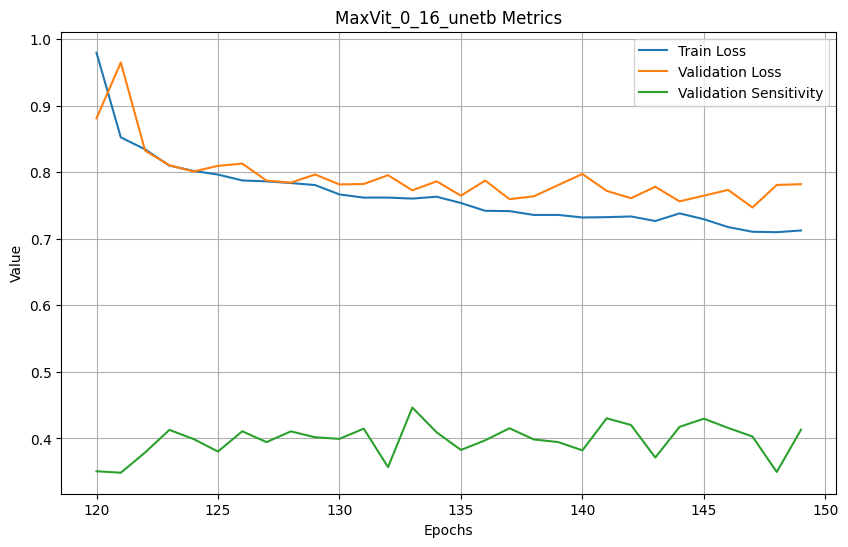

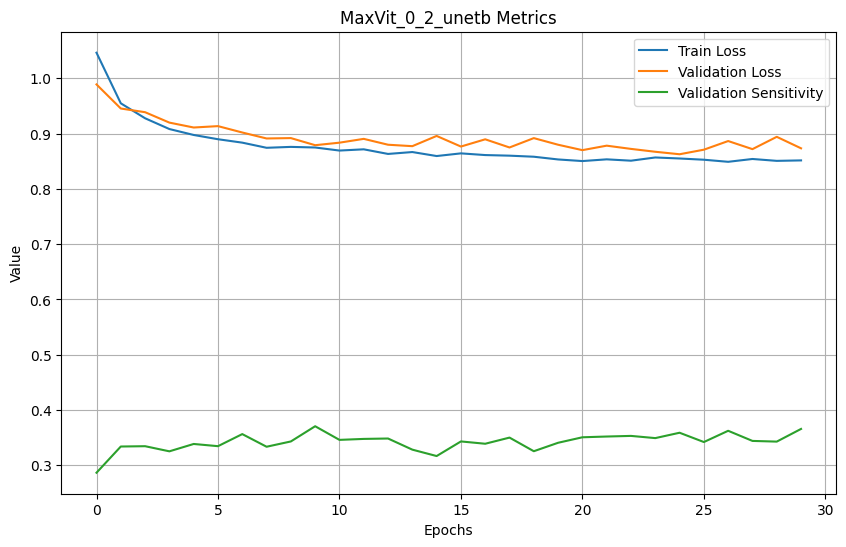

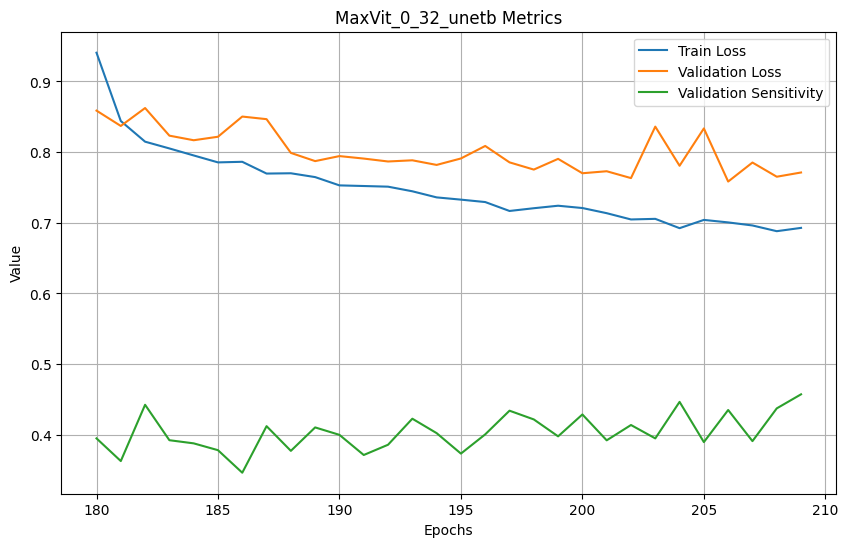

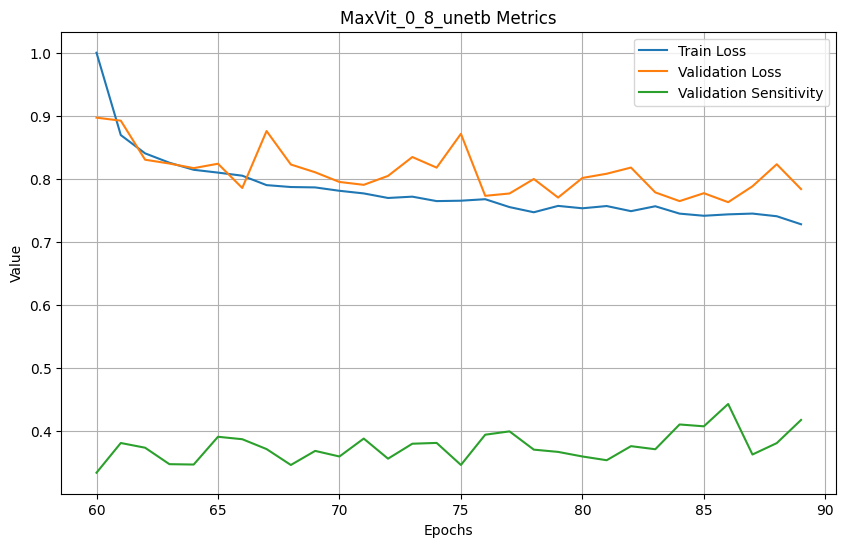

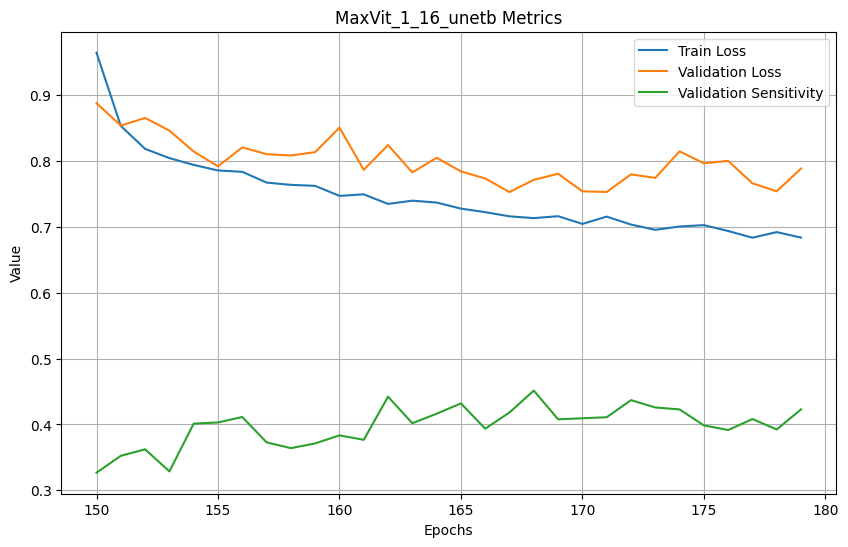

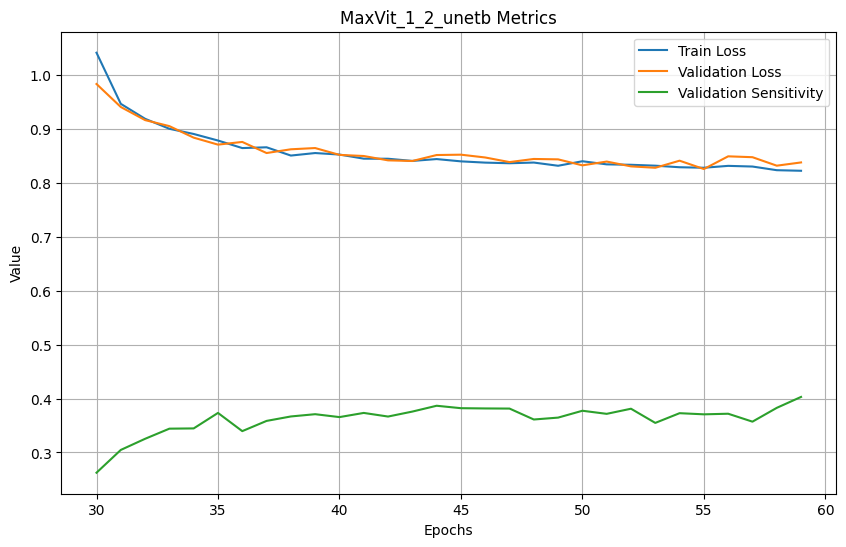

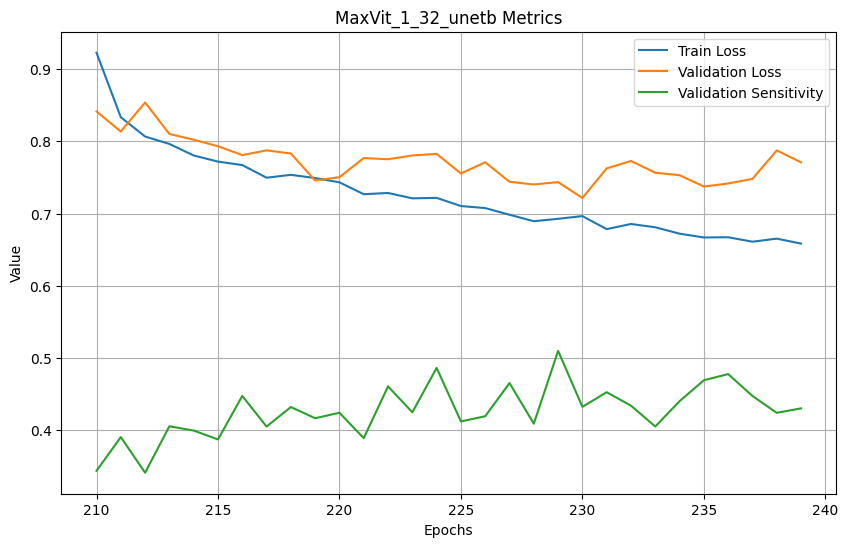

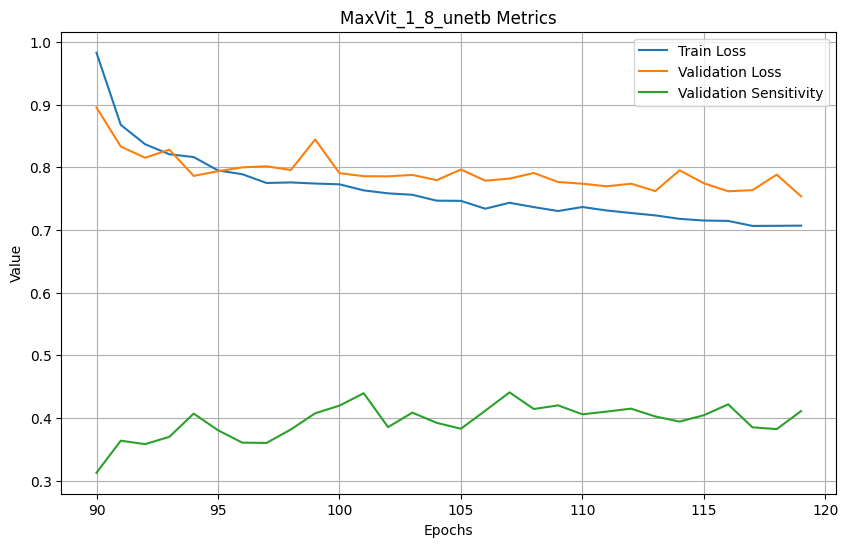

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("results/maxvit_layer_unetb.csv")
grouped_data = data.groupby('Model')

for model, model_data in grouped_data:
    plt.figure(figsize=(10, 6))
    plt.plot(model_data.index, model_data['train loss'], label='Train Loss')
    plt.plot(model_data.index, model_data['val loss'], label='Validation Loss')
    plt.plot(model_data.index, model_data['val sensitivity'], label='Validation Sensitivity')
    
    plt.title(f'{model} Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


### unet multi

In [21]:
class_weights = calculate_dr_class_weights(unetm_train_dataset)

Class Weights: [ 0.40443009  3.8864745   0.55102169 10.37159763  2.78664547]


In [22]:
layer_list = [[0, 2],
              [1, 2],
              [0, 8],
              [1, 8],
              [0, 16],
              [1, 16],
              [0, 32],
              [1, 32]]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30

all_results = pd.DataFrame(columns=["Model", "train loss", "val loss", "val accuracy", "val sensitivity"])

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    model = PreTrainedCNNModels("MaxVit", num_first_unfreeze, num_last_unfreeze, len(unetm_train_dataset.classes)).to(device)
    criterion=torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    print(f"-------------Training MaxVit with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers with unet multi data------------")
    model_result = train(model,
                         criterion,
                         optimizer,
                         (224,224),
                         unetm_train_dataloader,
                         unetm_val_dataloader,
                         'sensitivity',
                         num_epochs,
                         device,
                         f"MaxVit_{num_first_unfreeze}_{num_last_unfreeze}_unetm")
    
    all_results =  pd.concat([all_results, model_result])

all_results.to_csv("results/maxvit_layer_unetm.csv")


-------------Training MaxVit with 0 Unfrozen First Layers and 2 Unfrozen Last Layers with unet multi data------------


100%|██████████| 137/137 [00:37<00:00,  3.68it/s]


Epoch 1 completed, training loss: 1.1328061601541337
Validation loss: 1.02428497672081, Validation Accuracy: 58.81, Validation Sensitivty: 0.254777


100%|██████████| 137/137 [00:37<00:00,  3.67it/s]


Epoch 2 completed, training loss: 1.0022289752960205
Validation loss: 0.983963672320048, Validation Accuracy: 60.56, Validation Sensitivty: 0.288247
Best model saved


100%|██████████| 137/137 [00:37<00:00,  3.70it/s]


Epoch 3 completed, training loss: 0.9779235598814748
Validation loss: 0.9707632780075073, Validation Accuracy: 60.35, Validation Sensitivty: 0.286576


100%|██████████| 137/137 [00:37<00:00,  3.67it/s]


Epoch 4 completed, training loss: 0.9628562144119374
Validation loss: 0.9565284450848898, Validation Accuracy: 60.72, Validation Sensitivty: 0.304895
Best model saved


100%|██████████| 137/137 [00:37<00:00,  3.62it/s]


Epoch 5 completed, training loss: 0.9505385256161655
Validation loss: 0.9407295723756154, Validation Accuracy: 62.27, Validation Sensitivty: 0.323655
Best model saved


100%|██████████| 137/137 [00:37<00:00,  3.63it/s]


Epoch 6 completed, training loss: 0.9432358676499694
Validation loss: 0.9335008998711903, Validation Accuracy: 62.53, Validation Sensitivty: 0.322432


100%|██████████| 137/137 [00:37<00:00,  3.65it/s]


Epoch 7 completed, training loss: 0.9369209730712167
Validation loss: 0.9315911451975505, Validation Accuracy: 62.11, Validation Sensitivty: 0.311589


100%|██████████| 137/137 [00:37<00:00,  3.66it/s]


Epoch 8 completed, training loss: 0.9260154044541129
Validation loss: 0.9151018559932709, Validation Accuracy: 63.65, Validation Sensitivty: 0.337036
Best model saved


100%|██████████| 137/137 [00:37<00:00,  3.65it/s]


Epoch 9 completed, training loss: 0.928956044416358
Validation loss: 0.9229305843512218, Validation Accuracy: 63.65, Validation Sensitivty: 0.332386


100%|██████████| 137/137 [00:37<00:00,  3.66it/s]


Epoch 10 completed, training loss: 0.9281094339642212
Validation loss: 0.9114937444527944, Validation Accuracy: 63.97, Validation Sensitivty: 0.332992


100%|██████████| 137/137 [00:37<00:00,  3.62it/s]


Epoch 11 completed, training loss: 0.9264447132166285
Validation loss: 0.9174742698669434, Validation Accuracy: 63.28, Validation Sensitivty: 0.329307


100%|██████████| 137/137 [00:40<00:00,  3.37it/s]


Epoch 12 completed, training loss: 0.9234127328343635
Validation loss: 0.9213526646296183, Validation Accuracy: 62.59, Validation Sensitivty: 0.336776


100%|██████████| 137/137 [00:41<00:00,  3.32it/s]


Epoch 13 completed, training loss: 0.9159285456594759
Validation loss: 0.9223109722137451, Validation Accuracy: 62.05, Validation Sensitivty: 0.341819
Best model saved


100%|██████████| 137/137 [00:37<00:00,  3.69it/s]


Epoch 14 completed, training loss: 0.9206369845536504
Validation loss: 0.9257581770420075, Validation Accuracy: 62.37, Validation Sensitivty: 0.338612


100%|██████████| 137/137 [00:35<00:00,  3.84it/s]


Epoch 15 completed, training loss: 0.9183494774964605
Validation loss: 0.9114059885342916, Validation Accuracy: 63.70, Validation Sensitivty: 0.333135


100%|██████████| 137/137 [00:35<00:00,  3.90it/s]


Epoch 16 completed, training loss: 0.9117176928659425
Validation loss: 0.9247319400310516, Validation Accuracy: 62.91, Validation Sensitivty: 0.336424


100%|██████████| 137/137 [00:35<00:00,  3.85it/s]


Epoch 17 completed, training loss: 0.9151668526830464
Validation loss: 0.9220390121142069, Validation Accuracy: 63.28, Validation Sensitivty: 0.345112
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 18 completed, training loss: 0.9117636976450899
Validation loss: 0.9149474461873373, Validation Accuracy: 63.54, Validation Sensitivty: 0.332335


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 19 completed, training loss: 0.9113523503289606
Validation loss: 0.9086081047852834, Validation Accuracy: 64.13, Validation Sensitivty: 0.345790
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 20 completed, training loss: 0.9136045070460243
Validation loss: 0.9162270764509837, Validation Accuracy: 62.85, Validation Sensitivty: 0.314690


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 21 completed, training loss: 0.9100188599885816
Validation loss: 0.9160774171352386, Validation Accuracy: 63.49, Validation Sensitivty: 0.342630


100%|██████████| 137/137 [00:31<00:00,  4.37it/s]


Epoch 22 completed, training loss: 0.9084664156837184
Validation loss: 0.9316852211952209, Validation Accuracy: 62.80, Validation Sensitivty: 0.318222


100%|██████████| 137/137 [00:31<00:00,  4.37it/s]


Epoch 23 completed, training loss: 0.9077974248976604
Validation loss: 0.9162473638852437, Validation Accuracy: 63.01, Validation Sensitivty: 0.348422
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 24 completed, training loss: 0.9086410085650256
Validation loss: 0.9108970522880554, Validation Accuracy: 64.45, Validation Sensitivty: 0.311226


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 25 completed, training loss: 0.9075433690182484
Validation loss: 0.9162299414475759, Validation Accuracy: 63.86, Validation Sensitivty: 0.340777


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 26 completed, training loss: 0.9032685526096038
Validation loss: 0.9185844957828522, Validation Accuracy: 62.37, Validation Sensitivty: 0.323661


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 27 completed, training loss: 0.9016560346540743
Validation loss: 0.9001221696535746, Validation Accuracy: 64.34, Validation Sensitivty: 0.351882
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 28 completed, training loss: 0.9020502950153212
Validation loss: 0.8993206898371379, Validation Accuracy: 64.18, Validation Sensitivty: 0.342551


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 29 completed, training loss: 0.904162299458998
Validation loss: 0.9253154555956523, Validation Accuracy: 62.91, Validation Sensitivty: 0.312921


100%|██████████| 137/137 [00:31<00:00,  4.37it/s]


Epoch 30 completed, training loss: 0.8996248536736425
Validation loss: 0.8989921430746715, Validation Accuracy: 64.24, Validation Sensitivty: 0.335906
-------------Training MaxVit with 1 Unfrozen First Layers and 2 Unfrozen Last Layers with unet multi data------------


100%|██████████| 137/137 [00:47<00:00,  2.90it/s]


Epoch 1 completed, training loss: 1.1320145669644766
Validation loss: 1.0245195031166077, Validation Accuracy: 56.79, Validation Sensitivty: 0.245453


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 2 completed, training loss: 0.995394464826932
Validation loss: 0.956236602862676, Validation Accuracy: 62.05, Validation Sensitivty: 0.306401
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.92it/s]


Epoch 3 completed, training loss: 0.9640290223769028
Validation loss: 0.9376733342806498, Validation Accuracy: 61.79, Validation Sensitivty: 0.317692
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.92it/s]


Epoch 4 completed, training loss: 0.9450476321860821
Validation loss: 0.9326227088769277, Validation Accuracy: 62.11, Validation Sensitivty: 0.312774


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 5 completed, training loss: 0.9394073503730941
Validation loss: 0.9156503438949585, Validation Accuracy: 62.64, Validation Sensitivty: 0.313823


100%|██████████| 137/137 [00:46<00:00,  2.92it/s]


Epoch 6 completed, training loss: 0.9281142197386192
Validation loss: 0.9316118041674296, Validation Accuracy: 62.69, Validation Sensitivty: 0.306921


100%|██████████| 137/137 [00:46<00:00,  2.92it/s]


Epoch 7 completed, training loss: 0.9228748248441376
Validation loss: 0.8965047339598338, Validation Accuracy: 65.03, Validation Sensitivty: 0.360816
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 8 completed, training loss: 0.9173393210355383
Validation loss: 0.9051589866479238, Validation Accuracy: 63.38, Validation Sensitivty: 0.340469


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 9 completed, training loss: 0.909716170199596
Validation loss: 0.9083130558331808, Validation Accuracy: 63.76, Validation Sensitivty: 0.338075


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 10 completed, training loss: 0.9139193748905711
Validation loss: 0.8954185088475545, Validation Accuracy: 64.40, Validation Sensitivty: 0.332343


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 11 completed, training loss: 0.9018362338525535
Validation loss: 0.9079578538735708, Validation Accuracy: 64.13, Validation Sensitivty: 0.344986


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 12 completed, training loss: 0.902953087413398
Validation loss: 0.8889803528785706, Validation Accuracy: 65.67, Validation Sensitivty: 0.356215


100%|██████████| 137/137 [00:46<00:00,  2.95it/s]


Epoch 13 completed, training loss: 0.8987007589235793
Validation loss: 0.8867468456427257, Validation Accuracy: 64.93, Validation Sensitivty: 0.331272


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 14 completed, training loss: 0.8965661264684078
Validation loss: 0.8761989414691925, Validation Accuracy: 65.35, Validation Sensitivty: 0.359619


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 15 completed, training loss: 0.896467459462855
Validation loss: 0.8818772633870443, Validation Accuracy: 65.57, Validation Sensitivty: 0.375121
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 16 completed, training loss: 0.8928531556233873
Validation loss: 0.8903704444567363, Validation Accuracy: 64.72, Validation Sensitivty: 0.366318


100%|██████████| 137/137 [00:46<00:00,  2.95it/s]


Epoch 17 completed, training loss: 0.8924893171247774
Validation loss: 0.8826477805773417, Validation Accuracy: 65.09, Validation Sensitivty: 0.348249


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 18 completed, training loss: 0.8896267257467674
Validation loss: 0.906097271045049, Validation Accuracy: 64.93, Validation Sensitivty: 0.344939


100%|██████████| 137/137 [00:46<00:00,  2.95it/s]


Epoch 19 completed, training loss: 0.8887235078498394
Validation loss: 0.8781442602475484, Validation Accuracy: 65.89, Validation Sensitivty: 0.361300


100%|██████████| 137/137 [00:46<00:00,  2.95it/s]


Epoch 20 completed, training loss: 0.8841184917157584
Validation loss: 0.8708660960197449, Validation Accuracy: 66.26, Validation Sensitivty: 0.366871


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 21 completed, training loss: 0.8872180224335107
Validation loss: 0.8732584913571676, Validation Accuracy: 65.67, Validation Sensitivty: 0.361453


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 22 completed, training loss: 0.8833215754397594
Validation loss: 0.8953223625818888, Validation Accuracy: 65.19, Validation Sensitivty: 0.344296


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 23 completed, training loss: 0.8847388303192862
Validation loss: 0.8702705204486847, Validation Accuracy: 65.78, Validation Sensitivty: 0.362249


100%|██████████| 137/137 [00:46<00:00,  2.92it/s]


Epoch 24 completed, training loss: 0.8765427022084703
Validation loss: 0.8681405742963155, Validation Accuracy: 66.47, Validation Sensitivty: 0.369322


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 25 completed, training loss: 0.8863917767566486
Validation loss: 0.8984007020791371, Validation Accuracy: 64.08, Validation Sensitivty: 0.341118


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 26 completed, training loss: 0.8825111811178444
Validation loss: 0.892461504538854, Validation Accuracy: 65.35, Validation Sensitivty: 0.347324


100%|██████████| 137/137 [00:47<00:00,  2.91it/s]


Epoch 27 completed, training loss: 0.8845171911002946
Validation loss: 0.8623239517211914, Validation Accuracy: 65.83, Validation Sensitivty: 0.364796


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 28 completed, training loss: 0.8777451476041418
Validation loss: 0.8717722634474436, Validation Accuracy: 66.42, Validation Sensitivty: 0.348584


100%|██████████| 137/137 [00:46<00:00,  2.92it/s]


Epoch 29 completed, training loss: 0.8870937371776052
Validation loss: 0.8894578039646148, Validation Accuracy: 65.62, Validation Sensitivty: 0.336280


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 30 completed, training loss: 0.8750190852332289
Validation loss: 0.877008193731308, Validation Accuracy: 66.42, Validation Sensitivty: 0.390223
Best model saved
-------------Training MaxVit with 0 Unfrozen First Layers and 8 Unfrozen Last Layers with unet multi data------------


100%|██████████| 137/137 [00:31<00:00,  4.36it/s]


Epoch 1 completed, training loss: 1.016849911125907
Validation loss: 0.9383053998152415, Validation Accuracy: 61.95, Validation Sensitivty: 0.306515


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 2 completed, training loss: 0.9412437955828479
Validation loss: 0.9410451471805572, Validation Accuracy: 60.09, Validation Sensitivty: 0.316133
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.32it/s]


Epoch 3 completed, training loss: 0.9240438033194438
Validation loss: 0.942469205458959, Validation Accuracy: 61.20, Validation Sensitivty: 0.330060
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.39it/s]


Epoch 4 completed, training loss: 0.9178942498499459
Validation loss: 0.9126863320668538, Validation Accuracy: 63.86, Validation Sensitivty: 0.334970
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 5 completed, training loss: 0.907519647674839
Validation loss: 0.8896641174952189, Validation Accuracy: 64.77, Validation Sensitivty: 0.352302
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 6 completed, training loss: 0.8987945635823438
Validation loss: 0.8933970312277476, Validation Accuracy: 65.03, Validation Sensitivty: 0.346676


100%|██████████| 137/137 [00:31<00:00,  4.37it/s]


Epoch 7 completed, training loss: 0.9038260257157096
Validation loss: 0.9310427089532216, Validation Accuracy: 60.88, Validation Sensitivty: 0.326986


100%|██████████| 137/137 [00:31<00:00,  4.37it/s]


Epoch 8 completed, training loss: 0.8939330081870086
Validation loss: 0.9020238518714905, Validation Accuracy: 65.25, Validation Sensitivty: 0.338032


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 9 completed, training loss: 0.8904544071559488
Validation loss: 0.8858413239320119, Validation Accuracy: 65.03, Validation Sensitivty: 0.357768
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 10 completed, training loss: 0.8979188260370797
Validation loss: 0.8923024694124858, Validation Accuracy: 65.35, Validation Sensitivty: 0.325196


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 11 completed, training loss: 0.8941072952138246
Validation loss: 0.9355810205141704, Validation Accuracy: 61.84, Validation Sensitivty: 0.315980


100%|██████████| 137/137 [00:31<00:00,  4.39it/s]


Epoch 12 completed, training loss: 0.8882037931985228
Validation loss: 0.8813963830471039, Validation Accuracy: 65.46, Validation Sensitivty: 0.337012


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Epoch 13 completed, training loss: 0.8884938059061983
Validation loss: 0.8840172211329143, Validation Accuracy: 64.87, Validation Sensitivty: 0.361273
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.37it/s]


Epoch 14 completed, training loss: 0.8885046804908419
Validation loss: 0.895466027657191, Validation Accuracy: 64.18, Validation Sensitivty: 0.345778


100%|██████████| 137/137 [00:32<00:00,  4.27it/s]


Epoch 15 completed, training loss: 0.8781991122412856
Validation loss: 0.9000083247820536, Validation Accuracy: 64.34, Validation Sensitivty: 0.329716


100%|██████████| 137/137 [00:31<00:00,  4.32it/s]


Epoch 16 completed, training loss: 0.8851343989372253
Validation loss: 0.9176052749156952, Validation Accuracy: 63.86, Validation Sensitivty: 0.316926


100%|██████████| 137/137 [00:31<00:00,  4.32it/s]


Epoch 17 completed, training loss: 0.8814566553074078
Validation loss: 0.9020519355932871, Validation Accuracy: 65.19, Validation Sensitivty: 0.344398


100%|██████████| 137/137 [00:31<00:00,  4.33it/s]


Epoch 18 completed, training loss: 0.8738452526774719
Validation loss: 0.9049288153648376, Validation Accuracy: 63.49, Validation Sensitivty: 0.330361


100%|██████████| 137/137 [00:31<00:00,  4.33it/s]


Epoch 19 completed, training loss: 0.8762159813059508
Validation loss: 0.8755494435628255, Validation Accuracy: 66.26, Validation Sensitivty: 0.368237
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 20 completed, training loss: 0.8783393289050917
Validation loss: 0.8673471689224244, Validation Accuracy: 66.52, Validation Sensitivty: 0.365636


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 21 completed, training loss: 0.8759281208915431
Validation loss: 0.873033465941747, Validation Accuracy: 65.41, Validation Sensitivty: 0.360895


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 22 completed, training loss: 0.880197670772998
Validation loss: 0.8856694300969442, Validation Accuracy: 64.24, Validation Sensitivty: 0.345116


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 23 completed, training loss: 0.880278672615107
Validation loss: 0.8781980117162068, Validation Accuracy: 64.61, Validation Sensitivty: 0.347343


100%|██████████| 137/137 [00:31<00:00,  4.33it/s]


Epoch 24 completed, training loss: 0.8734621231573342
Validation loss: 0.8715482155481974, Validation Accuracy: 66.31, Validation Sensitivty: 0.367005


100%|██████████| 137/137 [00:31<00:00,  4.33it/s]


Epoch 25 completed, training loss: 0.8769193622317627
Validation loss: 0.8712448755900065, Validation Accuracy: 65.94, Validation Sensitivty: 0.345990


100%|██████████| 137/137 [00:31<00:00,  4.31it/s]


Epoch 26 completed, training loss: 0.8717259899543149
Validation loss: 0.8603352765242259, Validation Accuracy: 66.10, Validation Sensitivty: 0.375943
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.33it/s]


Epoch 27 completed, training loss: 0.8756543476216114
Validation loss: 0.9004307409127553, Validation Accuracy: 63.76, Validation Sensitivty: 0.328192


100%|██████████| 137/137 [00:31<00:00,  4.33it/s]


Epoch 28 completed, training loss: 0.8701338176309628
Validation loss: 0.8619895696640014, Validation Accuracy: 65.83, Validation Sensitivty: 0.374671


100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


Epoch 29 completed, training loss: 0.8715956067516856
Validation loss: 0.8621329208215077, Validation Accuracy: 66.42, Validation Sensitivty: 0.371394


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 30 completed, training loss: 0.8674760521763433
Validation loss: 0.8637997388839722, Validation Accuracy: 66.21, Validation Sensitivty: 0.361033
-------------Training MaxVit with 1 Unfrozen First Layers and 8 Unfrozen Last Layers with unet multi data------------


100%|██████████| 137/137 [00:46<00:00,  2.92it/s]


Epoch 1 completed, training loss: 1.0139064993301448
Validation loss: 0.9522897303104401, Validation Accuracy: 60.99, Validation Sensitivty: 0.293217


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 2 completed, training loss: 0.9318858163200155
Validation loss: 0.9166419506072998, Validation Accuracy: 63.86, Validation Sensitivty: 0.344104
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 3 completed, training loss: 0.908175024237946
Validation loss: 0.907405533393224, Validation Accuracy: 63.92, Validation Sensitivty: 0.345610
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 4 completed, training loss: 0.904311836200909
Validation loss: 0.8839624543984731, Validation Accuracy: 64.02, Validation Sensitivty: 0.352346
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 5 completed, training loss: 0.8943954667035681
Validation loss: 0.92697118918101, Validation Accuracy: 61.63, Validation Sensitivty: 0.324276


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 6 completed, training loss: 0.8803020263240285
Validation loss: 0.9182891468207042, Validation Accuracy: 62.37, Validation Sensitivty: 0.341917


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 7 completed, training loss: 0.8798081387568565
Validation loss: 0.8706247945626576, Validation Accuracy: 66.42, Validation Sensitivty: 0.387837
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 8 completed, training loss: 0.8701645122827405
Validation loss: 0.8635077814261118, Validation Accuracy: 66.10, Validation Sensitivty: 0.392333
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 9 completed, training loss: 0.8704632316192571
Validation loss: 0.8572045207023621, Validation Accuracy: 65.67, Validation Sensitivty: 0.366140


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 10 completed, training loss: 0.8731947541236877
Validation loss: 0.8528113782405853, Validation Accuracy: 65.25, Validation Sensitivty: 0.376139


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 11 completed, training loss: 0.8772231492682965
Validation loss: 0.8961192687352498, Validation Accuracy: 63.49, Validation Sensitivty: 0.323914


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 12 completed, training loss: 0.8716516808001664
Validation loss: 0.8684391379356384, Validation Accuracy: 67.54, Validation Sensitivty: 0.375408


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 13 completed, training loss: 0.8749894434518187
Validation loss: 0.8540182054042816, Validation Accuracy: 67.43, Validation Sensitivty: 0.388040


100%|██████████| 137/137 [00:46<00:00,  2.92it/s]


Epoch 14 completed, training loss: 0.8646484774394627
Validation loss: 0.8459370613098145, Validation Accuracy: 67.00, Validation Sensitivty: 0.360961


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 15 completed, training loss: 0.8571736873501409
Validation loss: 0.8854893505573272, Validation Accuracy: 64.02, Validation Sensitivty: 0.354295


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 16 completed, training loss: 0.8584572912132653
Validation loss: 0.8601561089356741, Validation Accuracy: 65.89, Validation Sensitivty: 0.369368


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 17 completed, training loss: 0.8474087236571486
Validation loss: 0.8605114777882894, Validation Accuracy: 66.63, Validation Sensitivty: 0.397119
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 18 completed, training loss: 0.8543843674833758
Validation loss: 0.891857753197352, Validation Accuracy: 64.24, Validation Sensitivty: 0.344617


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 19 completed, training loss: 0.8558905033299523
Validation loss: 0.9034682929515838, Validation Accuracy: 63.65, Validation Sensitivty: 0.367836


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 20 completed, training loss: 0.8516398820563824
Validation loss: 0.8397744794686636, Validation Accuracy: 65.89, Validation Sensitivty: 0.376912


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 21 completed, training loss: 0.8540438705117163
Validation loss: 0.8365870614846548, Validation Accuracy: 66.37, Validation Sensitivty: 0.364610


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 22 completed, training loss: 0.8534670707083096
Validation loss: 0.8474535385767619, Validation Accuracy: 67.38, Validation Sensitivty: 0.408406
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 23 completed, training loss: 0.8466866025089348
Validation loss: 0.8418929437796275, Validation Accuracy: 67.38, Validation Sensitivty: 0.382860


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 24 completed, training loss: 0.8469208317951564
Validation loss: 0.8579654693603516, Validation Accuracy: 64.93, Validation Sensitivty: 0.387183


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 25 completed, training loss: 0.8511781253083779
Validation loss: 0.8420350233713786, Validation Accuracy: 67.22, Validation Sensitivty: 0.371903


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 26 completed, training loss: 0.84350587025176
Validation loss: 0.8530250191688538, Validation Accuracy: 67.54, Validation Sensitivty: 0.427798
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 27 completed, training loss: 0.8491789541975425
Validation loss: 0.846952106555303, Validation Accuracy: 67.22, Validation Sensitivty: 0.397594


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 28 completed, training loss: 0.8529128741173848
Validation loss: 0.8384801705678304, Validation Accuracy: 67.86, Validation Sensitivty: 0.376580


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 29 completed, training loss: 0.84487771944408
Validation loss: 0.8476790308952331, Validation Accuracy: 67.43, Validation Sensitivty: 0.407513


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 30 completed, training loss: 0.8454645806855529
Validation loss: 0.8279559016227722, Validation Accuracy: 68.44, Validation Sensitivty: 0.385305
-------------Training MaxVit with 0 Unfrozen First Layers and 16 Unfrozen Last Layers with unet multi data------------


100%|██████████| 137/137 [00:31<00:00,  4.33it/s]


Epoch 1 completed, training loss: 1.0041747580479532
Validation loss: 0.9035200893878936, Validation Accuracy: 63.17, Validation Sensitivty: 0.331207


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 2 completed, training loss: 0.9269022889380908
Validation loss: 0.9019840002059937, Validation Accuracy: 63.81, Validation Sensitivty: 0.336064
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 3 completed, training loss: 0.9087953602310515
Validation loss: 0.8959172089894613, Validation Accuracy: 63.38, Validation Sensitivty: 0.334075


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 4 completed, training loss: 0.9006042754563102
Validation loss: 0.87001833319664, Validation Accuracy: 65.67, Validation Sensitivty: 0.336770
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


Epoch 5 completed, training loss: 0.8865700960159302
Validation loss: 0.8651847998301189, Validation Accuracy: 66.31, Validation Sensitivty: 0.364615
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


Epoch 6 completed, training loss: 0.8856137777767042
Validation loss: 0.865753972530365, Validation Accuracy: 65.73, Validation Sensitivty: 0.361563


100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


Epoch 7 completed, training loss: 0.8814858820316566
Validation loss: 0.8596679667631785, Validation Accuracy: 66.10, Validation Sensitivty: 0.347430


100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


Epoch 8 completed, training loss: 0.8717145262843501
Validation loss: 0.855900126695633, Validation Accuracy: 66.05, Validation Sensitivty: 0.338867


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 9 completed, training loss: 0.8671494161125517
Validation loss: 0.8362899164358775, Validation Accuracy: 67.86, Validation Sensitivty: 0.393850
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


Epoch 10 completed, training loss: 0.8616248691169015
Validation loss: 0.8706846197446187, Validation Accuracy: 65.78, Validation Sensitivty: 0.381520


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 11 completed, training loss: 0.8644675999662302
Validation loss: 0.8422786831855774, Validation Accuracy: 67.27, Validation Sensitivty: 0.358335


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 12 completed, training loss: 0.8566859786527871
Validation loss: 0.8607769548892975, Validation Accuracy: 66.05, Validation Sensitivty: 0.361147


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 13 completed, training loss: 0.8469828967630428
Validation loss: 0.8348884661992391, Validation Accuracy: 67.43, Validation Sensitivty: 0.408284
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


Epoch 14 completed, training loss: 0.8542879745908027
Validation loss: 0.8367576122283935, Validation Accuracy: 68.49, Validation Sensitivty: 0.374751


100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


Epoch 15 completed, training loss: 0.8430930541379609
Validation loss: 0.8629600902398428, Validation Accuracy: 67.48, Validation Sensitivty: 0.377015


100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


Epoch 16 completed, training loss: 0.8434539859312294
Validation loss: 0.8321115414301554, Validation Accuracy: 68.92, Validation Sensitivty: 0.387077


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 17 completed, training loss: 0.8407326066581002
Validation loss: 0.8214522361755371, Validation Accuracy: 69.08, Validation Sensitivty: 0.391246


100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


Epoch 18 completed, training loss: 0.8404600846506384
Validation loss: 0.8172800620396932, Validation Accuracy: 68.71, Validation Sensitivty: 0.411144
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 19 completed, training loss: 0.8376457569372915
Validation loss: 0.8136432409286499, Validation Accuracy: 68.71, Validation Sensitivty: 0.389612


100%|██████████| 137/137 [00:31<00:00,  4.33it/s]


Epoch 20 completed, training loss: 0.8337589167330387
Validation loss: 0.8245070338249206, Validation Accuracy: 68.28, Validation Sensitivty: 0.367655


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 21 completed, training loss: 0.8291507811441908
Validation loss: 0.8075766265392303, Validation Accuracy: 68.92, Validation Sensitivty: 0.364145


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 22 completed, training loss: 0.833992506900843
Validation loss: 0.832758617401123, Validation Accuracy: 69.40, Validation Sensitivty: 0.391540


100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


Epoch 23 completed, training loss: 0.8255737136750325
Validation loss: 0.8132216433684031, Validation Accuracy: 69.19, Validation Sensitivty: 0.400513


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 24 completed, training loss: 0.8245276195289445
Validation loss: 0.8342706779638926, Validation Accuracy: 68.44, Validation Sensitivty: 0.381544


100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


Epoch 25 completed, training loss: 0.8250216471887853
Validation loss: 0.8157712002595265, Validation Accuracy: 69.24, Validation Sensitivty: 0.369230


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 26 completed, training loss: 0.8142260578427002
Validation loss: 0.8108937859535217, Validation Accuracy: 69.45, Validation Sensitivty: 0.397774


100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


Epoch 27 completed, training loss: 0.8206287474527846
Validation loss: 0.8069376548131307, Validation Accuracy: 69.66, Validation Sensitivty: 0.397447


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 28 completed, training loss: 0.8107660486750359
Validation loss: 0.8271659145752589, Validation Accuracy: 68.71, Validation Sensitivty: 0.379332


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 29 completed, training loss: 0.8087052633292484
Validation loss: 0.8195711572964987, Validation Accuracy: 68.81, Validation Sensitivty: 0.378244


100%|██████████| 137/137 [00:31<00:00,  4.34it/s]


Epoch 30 completed, training loss: 0.8135466623480303
Validation loss: 0.8394664883613586, Validation Accuracy: 68.28, Validation Sensitivty: 0.393957
-------------Training MaxVit with 1 Unfrozen First Layers and 16 Unfrozen Last Layers with unet multi data------------


100%|██████████| 137/137 [00:46<00:00,  2.91it/s]


Epoch 1 completed, training loss: 1.0006465542055394
Validation loss: 0.9266237636407216, Validation Accuracy: 62.16, Validation Sensitivty: 0.319338


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 2 completed, training loss: 0.9213307195336279
Validation loss: 0.9545594612757365, Validation Accuracy: 61.63, Validation Sensitivty: 0.330405
Best model saved


100%|██████████| 137/137 [00:47<00:00,  2.90it/s]


Epoch 3 completed, training loss: 0.8984617034014124
Validation loss: 0.8668454408645629, Validation Accuracy: 66.63, Validation Sensitivty: 0.356792
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 4 completed, training loss: 0.8839368354665101
Validation loss: 0.8555166184902191, Validation Accuracy: 66.52, Validation Sensitivty: 0.375266
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 5 completed, training loss: 0.8746840958177609
Validation loss: 0.8689222514629364, Validation Accuracy: 64.87, Validation Sensitivty: 0.353575


100%|██████████| 137/137 [00:46<00:00,  2.92it/s]


Epoch 6 completed, training loss: 0.8711272547714901
Validation loss: 0.8502432902654012, Validation Accuracy: 67.00, Validation Sensitivty: 0.377749
Best model saved


100%|██████████| 137/137 [00:47<00:00,  2.90it/s]


Epoch 7 completed, training loss: 0.8625364120859299
Validation loss: 0.865309989452362, Validation Accuracy: 65.51, Validation Sensitivty: 0.398470
Best model saved


100%|██████████| 137/137 [00:47<00:00,  2.91it/s]


Epoch 8 completed, training loss: 0.8566888818775651
Validation loss: 0.8542912741502126, Validation Accuracy: 65.99, Validation Sensitivty: 0.365390


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 9 completed, training loss: 0.8503879008501986
Validation loss: 0.8655533174673716, Validation Accuracy: 66.58, Validation Sensitivty: 0.348619


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 10 completed, training loss: 0.853460387591898
Validation loss: 0.8434122999509176, Validation Accuracy: 67.48, Validation Sensitivty: 0.377215


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 11 completed, training loss: 0.8327483321628432
Validation loss: 0.8200453321139017, Validation Accuracy: 69.24, Validation Sensitivty: 0.398844
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 12 completed, training loss: 0.8369089521630837
Validation loss: 0.825783763329188, Validation Accuracy: 68.39, Validation Sensitivty: 0.379623


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 13 completed, training loss: 0.8272324413278677
Validation loss: 0.8108749111493428, Validation Accuracy: 68.92, Validation Sensitivty: 0.367882


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 14 completed, training loss: 0.8293069435732208
Validation loss: 0.8139382799466451, Validation Accuracy: 69.13, Validation Sensitivty: 0.398402


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 15 completed, training loss: 0.8318639528142274
Validation loss: 0.8003624776999155, Validation Accuracy: 70.09, Validation Sensitivty: 0.402148
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 16 completed, training loss: 0.8227754522414104
Validation loss: 0.8172050257523854, Validation Accuracy: 69.77, Validation Sensitivty: 0.383577


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 17 completed, training loss: 0.8110263043076452
Validation loss: 0.8081444362799327, Validation Accuracy: 68.28, Validation Sensitivty: 0.373264


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 18 completed, training loss: 0.8127818747158468
Validation loss: 0.8058646996815999, Validation Accuracy: 69.88, Validation Sensitivty: 0.392763


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 19 completed, training loss: 0.8165536553320223
Validation loss: 0.7958461860815684, Validation Accuracy: 70.14, Validation Sensitivty: 0.404543
Best model saved


100%|██████████| 137/137 [00:47<00:00,  2.88it/s]


Epoch 20 completed, training loss: 0.8074906303064666
Validation loss: 0.8026587903499603, Validation Accuracy: 69.77, Validation Sensitivty: 0.435829
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 21 completed, training loss: 0.810012656841835
Validation loss: 0.7970175544420878, Validation Accuracy: 70.73, Validation Sensitivty: 0.436917
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 22 completed, training loss: 0.7981598938468599
Validation loss: 0.8050057192643484, Validation Accuracy: 70.57, Validation Sensitivty: 0.435607


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 23 completed, training loss: 0.7971364612126872
Validation loss: 0.7938957115014394, Validation Accuracy: 70.30, Validation Sensitivty: 0.402819


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 24 completed, training loss: 0.8070675769861597
Validation loss: 0.799226576089859, Validation Accuracy: 70.30, Validation Sensitivty: 0.398978


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 25 completed, training loss: 0.7989592038801987
Validation loss: 0.7962405880292257, Validation Accuracy: 70.30, Validation Sensitivty: 0.420891


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 26 completed, training loss: 0.7994473206735876
Validation loss: 0.7847908933957418, Validation Accuracy: 71.15, Validation Sensitivty: 0.405750


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 27 completed, training loss: 0.8057002046682539
Validation loss: 0.7842164119084676, Validation Accuracy: 70.14, Validation Sensitivty: 0.384085


100%|██████████| 137/137 [00:46<00:00,  2.92it/s]


Epoch 28 completed, training loss: 0.7895678982247402
Validation loss: 0.7947497169176737, Validation Accuracy: 70.20, Validation Sensitivty: 0.390737


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 29 completed, training loss: 0.7924951504181771
Validation loss: 0.7965044558048249, Validation Accuracy: 70.46, Validation Sensitivty: 0.382379


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 30 completed, training loss: 0.7960946942767958
Validation loss: 0.7928329189618428, Validation Accuracy: 69.88, Validation Sensitivty: 0.415664
-------------Training MaxVit with 0 Unfrozen First Layers and 32 Unfrozen Last Layers with unet multi data------------


100%|██████████| 137/137 [00:31<00:00,  4.30it/s]


Epoch 1 completed, training loss: 0.9767553297272564
Validation loss: 0.8991151273250579, Validation Accuracy: 64.02, Validation Sensitivty: 0.342586


100%|██████████| 137/137 [00:31<00:00,  4.32it/s]


Epoch 2 completed, training loss: 0.9093431578065357
Validation loss: 0.855121131738027, Validation Accuracy: 67.11, Validation Sensitivty: 0.375581
Best model saved


100%|██████████| 137/137 [00:32<00:00,  4.24it/s]


Epoch 3 completed, training loss: 0.8931850251490182
Validation loss: 0.8648417671521504, Validation Accuracy: 66.68, Validation Sensitivty: 0.374779


100%|██████████| 137/137 [00:32<00:00,  4.26it/s]


Epoch 4 completed, training loss: 0.884313717810777
Validation loss: 0.8488997717698415, Validation Accuracy: 66.79, Validation Sensitivty: 0.373070


100%|██████████| 137/137 [00:32<00:00,  4.26it/s]


Epoch 5 completed, training loss: 0.8636159544443562
Validation loss: 0.8660788377126057, Validation Accuracy: 65.19, Validation Sensitivty: 0.364443


100%|██████████| 137/137 [00:32<00:00,  4.27it/s]


Epoch 6 completed, training loss: 0.8492618290177227
Validation loss: 0.8388769825299581, Validation Accuracy: 67.38, Validation Sensitivty: 0.372154


100%|██████████| 137/137 [00:32<00:00,  4.27it/s]


Epoch 7 completed, training loss: 0.846018168177918
Validation loss: 0.8442623635133107, Validation Accuracy: 67.54, Validation Sensitivty: 0.349907


100%|██████████| 137/137 [00:32<00:00,  4.27it/s]


Epoch 8 completed, training loss: 0.8385355729256233
Validation loss: 0.8419402023156484, Validation Accuracy: 66.84, Validation Sensitivty: 0.340446


100%|██████████| 137/137 [00:32<00:00,  4.28it/s]


Epoch 9 completed, training loss: 0.8402763069981206
Validation loss: 0.8378500421841939, Validation Accuracy: 67.54, Validation Sensitivty: 0.351569


100%|██████████| 137/137 [00:32<00:00,  4.27it/s]


Epoch 10 completed, training loss: 0.8372005015394114
Validation loss: 0.8218074162801107, Validation Accuracy: 68.07, Validation Sensitivty: 0.384943
Best model saved


100%|██████████| 137/137 [00:31<00:00,  4.29it/s]


Epoch 11 completed, training loss: 0.8241941332817078
Validation loss: 0.8229180693626403, Validation Accuracy: 68.71, Validation Sensitivty: 0.370414


100%|██████████| 137/137 [00:32<00:00,  4.27it/s]


Epoch 12 completed, training loss: 0.8240384350727944
Validation loss: 0.8264706671237946, Validation Accuracy: 68.07, Validation Sensitivty: 0.379822


100%|██████████| 137/137 [00:32<00:00,  4.26it/s]


Epoch 13 completed, training loss: 0.8156058592517881
Validation loss: 0.8128347039222718, Validation Accuracy: 69.13, Validation Sensitivty: 0.422318
Best model saved


100%|██████████| 137/137 [00:32<00:00,  4.28it/s]


Epoch 14 completed, training loss: 0.8185528003386338
Validation loss: 0.8081148465474447, Validation Accuracy: 69.03, Validation Sensitivty: 0.398282


100%|██████████| 137/137 [00:32<00:00,  4.23it/s]


Epoch 15 completed, training loss: 0.813137922408807
Validation loss: 0.7988008280595144, Validation Accuracy: 69.40, Validation Sensitivty: 0.404158


100%|██████████| 137/137 [00:32<00:00,  4.25it/s]


Epoch 16 completed, training loss: 0.8056189661478474
Validation loss: 0.8204318284988403, Validation Accuracy: 69.13, Validation Sensitivty: 0.384889


100%|██████████| 137/137 [00:32<00:00,  4.26it/s]


Epoch 17 completed, training loss: 0.8055933326700307
Validation loss: 0.7945212503274282, Validation Accuracy: 70.30, Validation Sensitivty: 0.417095


100%|██████████| 137/137 [00:31<00:00,  4.30it/s]


Epoch 18 completed, training loss: 0.7964115186329306
Validation loss: 0.7969962517420451, Validation Accuracy: 70.04, Validation Sensitivty: 0.416526


100%|██████████| 137/137 [00:31<00:00,  4.31it/s]


Epoch 19 completed, training loss: 0.8009488504298412
Validation loss: 0.8182068387667338, Validation Accuracy: 68.87, Validation Sensitivty: 0.365361


100%|██████████| 137/137 [00:31<00:00,  4.31it/s]


Epoch 20 completed, training loss: 0.788987954167554
Validation loss: 0.827048103014628, Validation Accuracy: 69.24, Validation Sensitivty: 0.373833


100%|██████████| 137/137 [00:32<00:00,  4.27it/s]


Epoch 21 completed, training loss: 0.7956612597416787
Validation loss: 0.8191705167293548, Validation Accuracy: 70.04, Validation Sensitivty: 0.435775
Best model saved


100%|██████████| 137/137 [00:32<00:00,  4.24it/s]


Epoch 22 completed, training loss: 0.7890899268380047
Validation loss: 0.7954185863335927, Validation Accuracy: 70.52, Validation Sensitivty: 0.420135


100%|██████████| 137/137 [00:32<00:00,  4.26it/s]


Epoch 23 completed, training loss: 0.7871875077703573
Validation loss: 0.8018255571524302, Validation Accuracy: 70.30, Validation Sensitivty: 0.393591


100%|██████████| 137/137 [00:32<00:00,  4.26it/s]


Epoch 24 completed, training loss: 0.7863724475359395
Validation loss: 0.8024171074231465, Validation Accuracy: 70.36, Validation Sensitivty: 0.378890


100%|██████████| 137/137 [00:32<00:00,  4.27it/s]


Epoch 25 completed, training loss: 0.7859800579774119
Validation loss: 0.7962476710478464, Validation Accuracy: 70.57, Validation Sensitivty: 0.432464


100%|██████████| 137/137 [00:32<00:00,  4.26it/s]


Epoch 26 completed, training loss: 0.7769595045242866
Validation loss: 0.8158194621404012, Validation Accuracy: 69.45, Validation Sensitivty: 0.389047


100%|██████████| 137/137 [00:32<00:00,  4.28it/s]


Epoch 27 completed, training loss: 0.7781031003398616
Validation loss: 0.8081784804662069, Validation Accuracy: 69.61, Validation Sensitivty: 0.396726


100%|██████████| 137/137 [00:32<00:00,  4.27it/s]


Epoch 28 completed, training loss: 0.7815647656030028
Validation loss: 0.8056848545869192, Validation Accuracy: 68.87, Validation Sensitivty: 0.427382


100%|██████████| 137/137 [00:32<00:00,  4.27it/s]


Epoch 29 completed, training loss: 0.7731631876778429
Validation loss: 0.8072077512741089, Validation Accuracy: 70.20, Validation Sensitivty: 0.400334


100%|██████████| 137/137 [00:32<00:00,  4.27it/s]


Epoch 30 completed, training loss: 0.7761714480219096
Validation loss: 0.7871983846028646, Validation Accuracy: 71.00, Validation Sensitivty: 0.410867
-------------Training MaxVit with 1 Unfrozen First Layers and 32 Unfrozen Last Layers with unet multi data------------


100%|██████████| 137/137 [00:47<00:00,  2.91it/s]


Epoch 1 completed, training loss: 0.9851958268750323
Validation loss: 0.9222086985905965, Validation Accuracy: 64.24, Validation Sensitivty: 0.350796


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 2 completed, training loss: 0.9064604400718299
Validation loss: 0.89243643283844, Validation Accuracy: 65.30, Validation Sensitivty: 0.323228


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 3 completed, training loss: 0.8679593248959006
Validation loss: 0.8644463002681733, Validation Accuracy: 66.68, Validation Sensitivty: 0.359853
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 4 completed, training loss: 0.8665520200764176
Validation loss: 0.8533569514751435, Validation Accuracy: 67.06, Validation Sensitivty: 0.355283


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 5 completed, training loss: 0.8532585358097605
Validation loss: 0.8409719487031301, Validation Accuracy: 68.39, Validation Sensitivty: 0.386701
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 6 completed, training loss: 0.8332173980935647
Validation loss: 0.8171810507774353, Validation Accuracy: 69.45, Validation Sensitivty: 0.372321


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 7 completed, training loss: 0.8241883659884878
Validation loss: 0.8105398714542389, Validation Accuracy: 69.08, Validation Sensitivty: 0.398296
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 8 completed, training loss: 0.8194134326746864
Validation loss: 0.8192765712738037, Validation Accuracy: 70.09, Validation Sensitivty: 0.396438


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 9 completed, training loss: 0.8258658625783711
Validation loss: 0.8112807432810466, Validation Accuracy: 69.72, Validation Sensitivty: 0.424387
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 10 completed, training loss: 0.8206226534216944
Validation loss: 0.7922826528549194, Validation Accuracy: 70.62, Validation Sensitivty: 0.394192


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 11 completed, training loss: 0.8100304442600612
Validation loss: 0.7978780547777812, Validation Accuracy: 69.98, Validation Sensitivty: 0.406805


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 12 completed, training loss: 0.8057610231594448
Validation loss: 0.8042175114154816, Validation Accuracy: 70.57, Validation Sensitivty: 0.405749


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 13 completed, training loss: 0.7958166194658209
Validation loss: 0.791394156217575, Validation Accuracy: 69.98, Validation Sensitivty: 0.417561


100%|██████████| 137/137 [00:47<00:00,  2.90it/s]


Epoch 14 completed, training loss: 0.78915656091523
Validation loss: 0.7919961929321289, Validation Accuracy: 69.88, Validation Sensitivty: 0.452291
Best model saved


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 15 completed, training loss: 0.7794902072335682
Validation loss: 0.7892630418141683, Validation Accuracy: 70.41, Validation Sensitivty: 0.407261


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 16 completed, training loss: 0.7832487490925476
Validation loss: 0.7874789615472158, Validation Accuracy: 70.52, Validation Sensitivty: 0.417005


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 17 completed, training loss: 0.7760780962714313
Validation loss: 0.7914236426353455, Validation Accuracy: 70.46, Validation Sensitivty: 0.409453


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 18 completed, training loss: 0.7832857788044171
Validation loss: 0.8131158689657847, Validation Accuracy: 70.36, Validation Sensitivty: 0.375918


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 19 completed, training loss: 0.7747291091584811
Validation loss: 0.7761689732472102, Validation Accuracy: 71.31, Validation Sensitivty: 0.389600


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 20 completed, training loss: 0.7638251977245303
Validation loss: 0.7805129547913869, Validation Accuracy: 71.05, Validation Sensitivty: 0.431364


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 21 completed, training loss: 0.764101361706309
Validation loss: 0.7759768426418304, Validation Accuracy: 71.47, Validation Sensitivty: 0.420785


100%|██████████| 137/137 [00:47<00:00,  2.90it/s]


Epoch 22 completed, training loss: 0.7644870259465962
Validation loss: 0.7910150468349457, Validation Accuracy: 70.89, Validation Sensitivty: 0.400863


100%|██████████| 137/137 [00:47<00:00,  2.91it/s]


Epoch 23 completed, training loss: 0.7458834639430916
Validation loss: 0.807505065202713, Validation Accuracy: 70.36, Validation Sensitivty: 0.392849


100%|██████████| 137/137 [00:47<00:00,  2.91it/s]


Epoch 24 completed, training loss: 0.7580283954195732
Validation loss: 0.7864298264185587, Validation Accuracy: 70.04, Validation Sensitivty: 0.420510


100%|██████████| 137/137 [00:46<00:00,  2.92it/s]


Epoch 25 completed, training loss: 0.755383718622862
Validation loss: 0.7803571174542109, Validation Accuracy: 70.84, Validation Sensitivty: 0.400184


100%|██████████| 137/137 [00:47<00:00,  2.91it/s]


Epoch 26 completed, training loss: 0.7426921357638645
Validation loss: 0.7803458074728647, Validation Accuracy: 71.37, Validation Sensitivty: 0.433755


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Epoch 27 completed, training loss: 0.746648538721739
Validation loss: 0.7802314321200053, Validation Accuracy: 71.37, Validation Sensitivty: 0.411096


100%|██████████| 137/137 [00:47<00:00,  2.89it/s]


Epoch 28 completed, training loss: 0.7404150706138054
Validation loss: 0.7998439153035481, Validation Accuracy: 70.94, Validation Sensitivty: 0.424737


100%|██████████| 137/137 [00:47<00:00,  2.89it/s]


Epoch 29 completed, training loss: 0.7378863152796334
Validation loss: 0.7643076717853546, Validation Accuracy: 71.79, Validation Sensitivty: 0.446775


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Epoch 30 completed, training loss: 0.7404003617537283
Validation loss: 0.7670961161454518, Validation Accuracy: 71.63, Validation Sensitivty: 0.416423


In [23]:
layer_list = [[0, 2],
              [1, 2],
              [0, 8],
              [1, 8],
              [0, 16],
              [1, 16],
              [0, 32],
              [1, 32]]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for num_first_unfreeze, num_last_unfreeze in layer_list:

    #clear cuda memory
    torch.cuda.empty_cache()
    gc.collect()

    best_model = torch.load(f'../models/cnn/MaxVit_{num_first_unfreeze}_{num_last_unfreeze}_unetm_best.pt')
    last_model = torch.load(f'../models/cnn/MaxVit_{num_first_unfreeze}_{num_last_unfreeze}_unetm_last.pt')
    criterion=torch.nn.CrossEntropyLoss()

    print(f"-------------Evaluating Maxvit with {num_first_unfreeze} Unfrozen First Layers and {num_last_unfreeze} Unfrozen Last Layers with unetm data------------")
    loss, accuracy, sensitivity = eval(best_model,
                                        criterion,
                                        (224,224),
                                        unetm_test_dataloader,
                                        device)
    print(f"Best Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}")
    loss, accuracy, sensitivity = eval(last_model,
                                        criterion,
                                        (224,224),
                                        unetm_test_dataloader,
                                        device)
    print(f"Last Model - Test Loss: {loss}, Test Accuracy: {accuracy}, Test Sensitivity: {sensitivity}\n")

-------------Evaluating Maxvit with 0 Unfrozen First Layers and 2 Unfrozen Last Layers with unetm data------------
Best Model - Test Loss: 0.8818404356638591, Test Accuracy: 65.46035125066525, Test Sensitivity: 0.3482216987183034
Last Model - Test Loss: 0.8771194855372111, Test Accuracy: 65.1942522618414, Test Sensitivity: 0.3497318888595967

-------------Evaluating Maxvit with 1 Unfrozen First Layers and 2 Unfrozen Last Layers with unetm data------------
Best Model - Test Loss: 0.8445430000623068, Test Accuracy: 67.21660457690261, Test Sensitivity: 0.3528920588595806
Last Model - Test Loss: 0.841420304775238, Test Accuracy: 67.21660457690261, Test Sensitivity: 0.3459852722851714

-------------Evaluating Maxvit with 0 Unfrozen First Layers and 8 Unfrozen Last Layers with unetm data------------
Best Model - Test Loss: 0.8243689586718878, Test Accuracy: 66.63118680149014, Test Sensitivity: 0.3759113901736569
Last Model - Test Loss: 0.8397448321183523, Test Accuracy: 66.36508781266632, Te

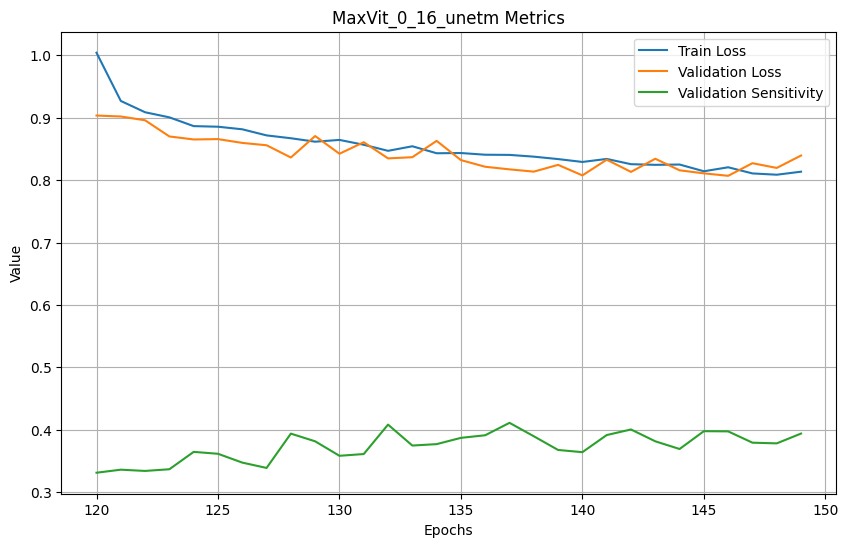

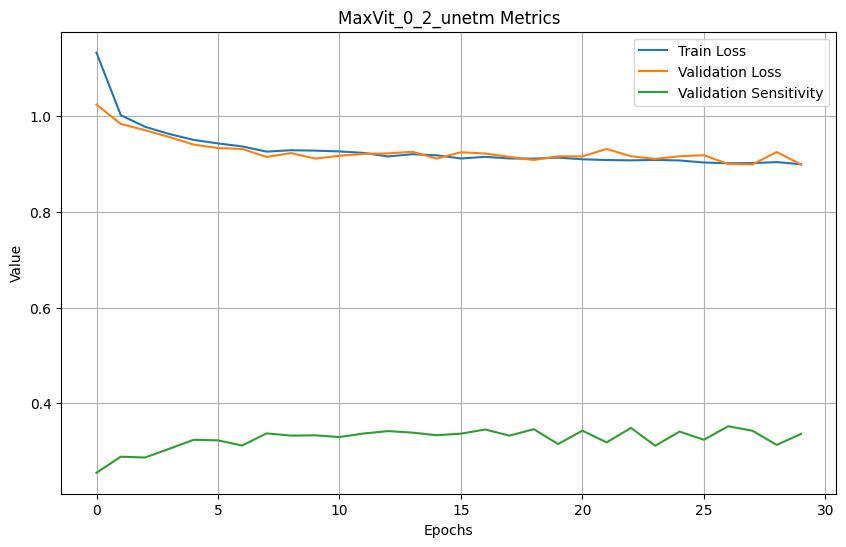

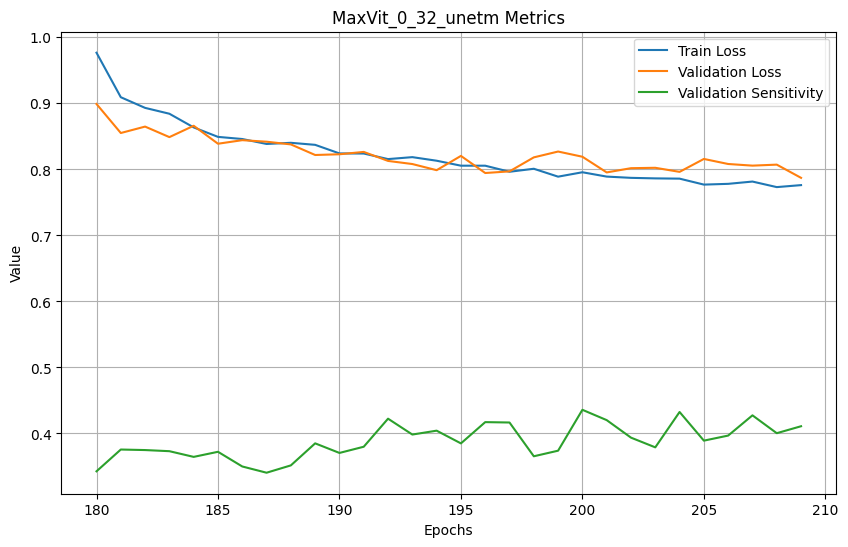

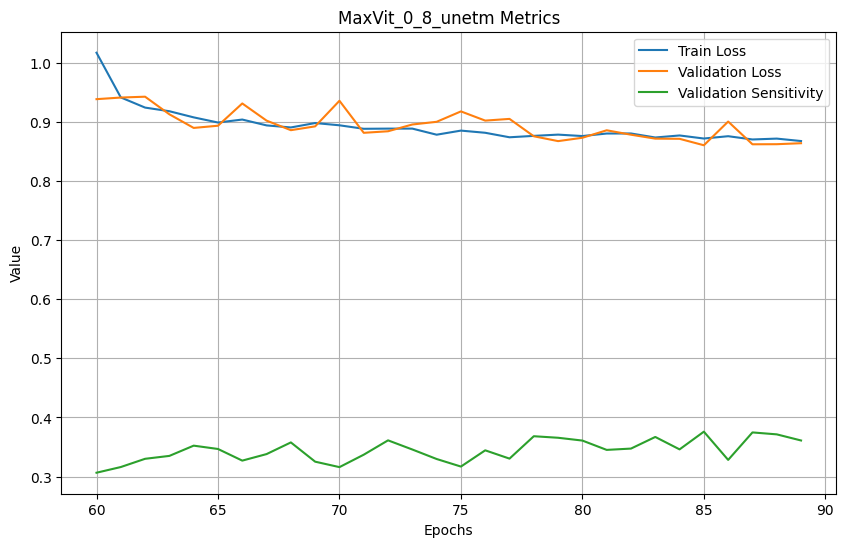

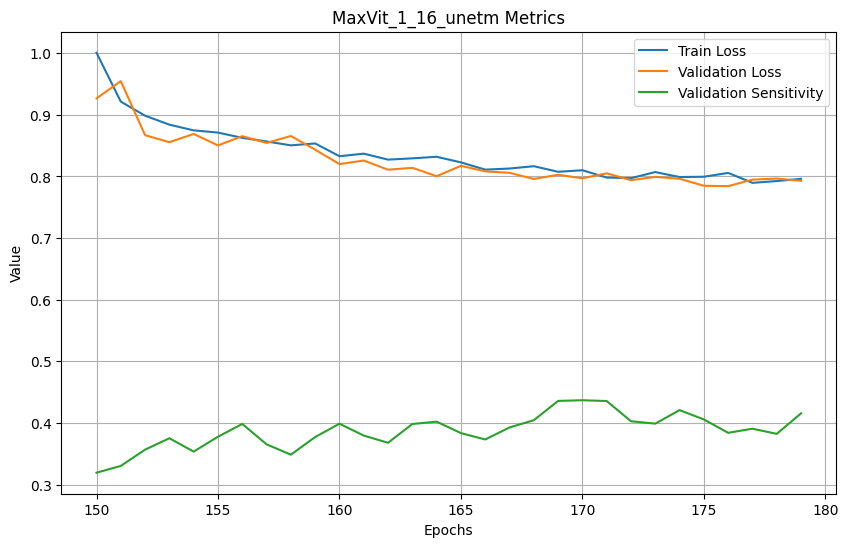

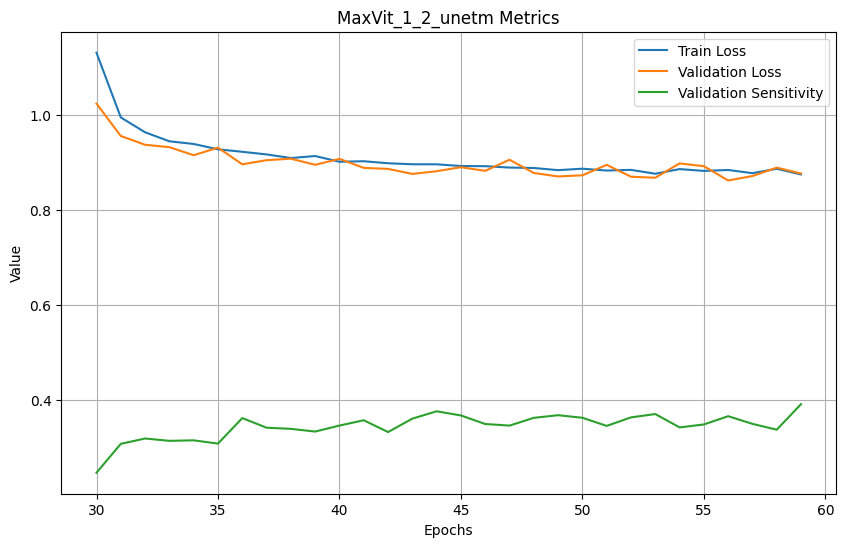

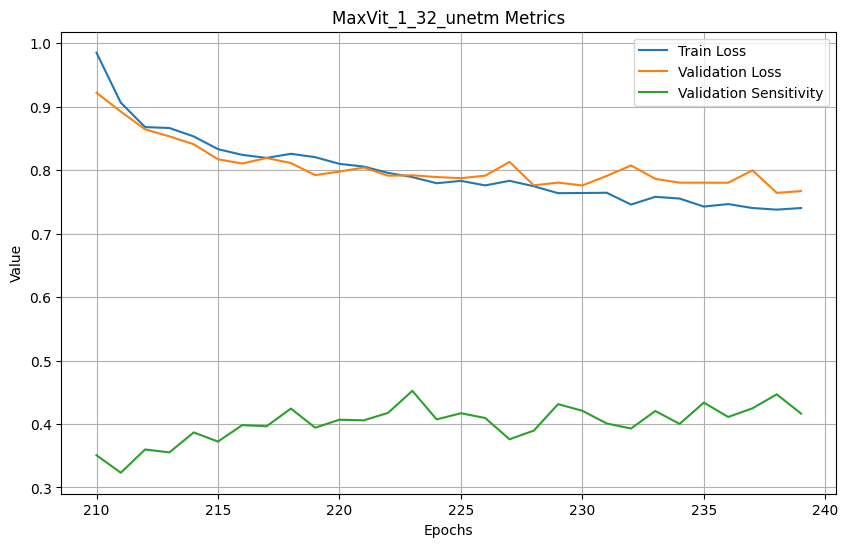

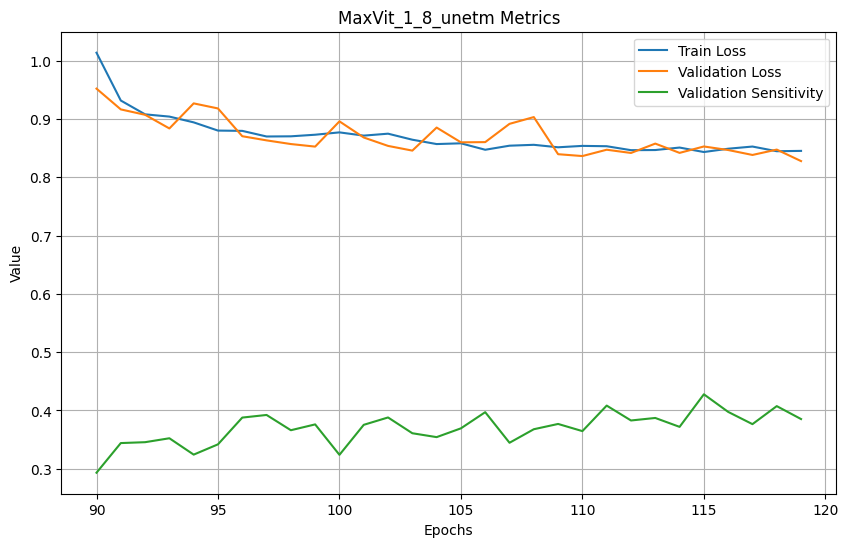

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("results/maxvit_layer_unetm.csv")
grouped_data = data.groupby('Model')

for model, model_data in grouped_data:
    plt.figure(figsize=(10, 6))
    plt.plot(model_data.index, model_data['train loss'], label='Train Loss')
    plt.plot(model_data.index, model_data['val loss'], label='Validation Loss')
    plt.plot(model_data.index, model_data['val sensitivity'], label='Validation Sensitivity')
    
    plt.title(f'{model} Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
